In [9]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
import matplotlib.pyplot as plt

In [6]:
base_url = 'https://understat.com/league'
leagues = ['La_liga', 'EPL', 'Bundesliga', 'Serie_A', 'Ligue_1', 'RFPL']
seasons = ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']

In [8]:
for league in leagues:
    for season in seasons:
        url = base_url+'/'+league+'/'+season
        res = requests.get(url)
        soup = BeautifulSoup(res.content, "lxml")

        # Based on the structure of the webpage, I found that data is in the JSON variable, under 'script' tags
        scripts = soup.find_all('script')
        
        string_with_json_obj = ''

        # Find data for teams
        for el in scripts:
            if 'teamsData' in str(el):
              string_with_json_obj = str(el).strip()

        #print(string_with_json_obj)
        
        # strip unnecessary symbols and get only JSON data
        ind_start = string_with_json_obj.index("('")+2
        ind_end = string_with_json_obj.index("')")
        json_data = string_with_json_obj[ind_start:ind_end]

        json_data = json_data.encode('utf8').decode('unicode_escape')

        #print(json_data)
        
        data = json.loads(json_data)
        
        # Get teams and their relevant ids and put them into separate dictionary
        teams = {}
        for id in data.keys():
          teams[id] = data[id]['title']
        
        #print(data)
        #print(teams)
        
        # EDA to get a feeling of how the JSON is structured
        # Column names are all the same, so we just use first element
        columns = []
        # Check the sample of values per each column
        values = []
        for id in data.keys():
            columns = list(data[id]['history'][0].keys())
            values = list(data[id]['history'][0].values())
            break
            
        #print(columns)
        #print(values)
        
        # Getting data for all teams
        dataframes = {}
        for id, team in teams.items():
            teams_data = []
            for row in data[id]['history']:
                teams_data.append(list(row.values()))

            all_teams_df = pd.DataFrame(teams_data, columns=columns)
            dataframes[team] = all_teams_df
            #print(f'Added data for {team}.')
            
        for team, df in dataframes.items():
            dataframes[team]['ppda_coef'] = dataframes[team]['ppda'].apply(lambda x: x['att']/x['def'] if x['def'] != 0 else 0)
            dataframes[team]['oppda_coef'] = dataframes[team]['ppda_allowed'].apply(lambda x: x['att']/x['def'] if x['def'] != 0 else 0)
            
        #dataframes.get('Barcelona', 'Nema te momčadi!')
        
        cols_to_sum = ['xG', 'xGA', 'npxG', 'npxGA', 'deep', 'deep_allowed', 'scored', 'missed', 'xpts', 'wins', 'draws', 'loses', 'pts', 'npxGD']
        cols_to_mean = ['ppda_coef', 'oppda_coef']
        
        frames = []
        for team, df in dataframes.items():
            sum_data = pd.DataFrame(df[cols_to_sum].sum()).transpose()
            mean_data = pd.DataFrame(df[cols_to_mean].mean()).transpose()
            final_df = sum_data.join(mean_data)
            final_df['team'] = team
            final_df['matches'] = len(df)
            frames.append(final_df)

        full_stat = pd.concat(frames)
        full_stat = full_stat[['team', 'matches', 'wins', 'draws', 'loses', 'scored', 'missed', 'pts', 'xG', 'npxG', 'xGA', 'npxGA', 'npxGD', 'ppda_coef', 'oppda_coef', 'deep', 'deep_allowed', 'xpts']]
        
        full_stat.sort_values('pts', ascending=False, inplace=True)
        full_stat.reset_index(inplace=True, drop=True)
        full_stat['position'] = range(1,len(full_stat)+1)
        full_stat['xG_diff'] = full_stat['xG'] - full_stat['scored']
        full_stat['xGA_diff'] = full_stat['xGA'] - full_stat['missed']
        full_stat['xpts_diff'] = full_stat['xpts'] - full_stat['pts']
        cols_to_int = ['wins', 'draws', 'loses', 'scored', 'missed', 'pts', 'deep', 'deep_allowed']
        full_stat[cols_to_int] = full_stat[cols_to_int].astype(int)
        
        col_order = ['position','team', 'matches', 'wins', 'draws', 'loses', 'scored', 'missed', 'pts', 'xG', 'xG_diff', 'npxG', 'xGA', 'xGA_diff', 'npxGA', 'npxGD', 'ppda_coef', 'oppda_coef', 'deep', 'deep_allowed', 'xpts', 'xpts_diff']
        full_stat = full_stat[col_order]
        full_stat.columns = ['#', 'team', 'M', 'W', 'D', 'L', 'G', 'GA', 'PTS', 'xG', 'xG_diff', 'NPxG', 'xGA', 'xGA_diff', 'NPxGA', 'NPxGD', 'PPDA', 'OPPDA', 'DC', 'ODC', 'xPTS', 'xPTS_diff']
        pd.options.display.float_format = '{:,.2f}'.format
        
        full_stat.to_csv(f'{league}_{season}.csv', index=False)

C:\Users\G. Torbar\anaconda3\envs\Algebra\Lib\site-packages\pandas\plotting\_matplotlib\core.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


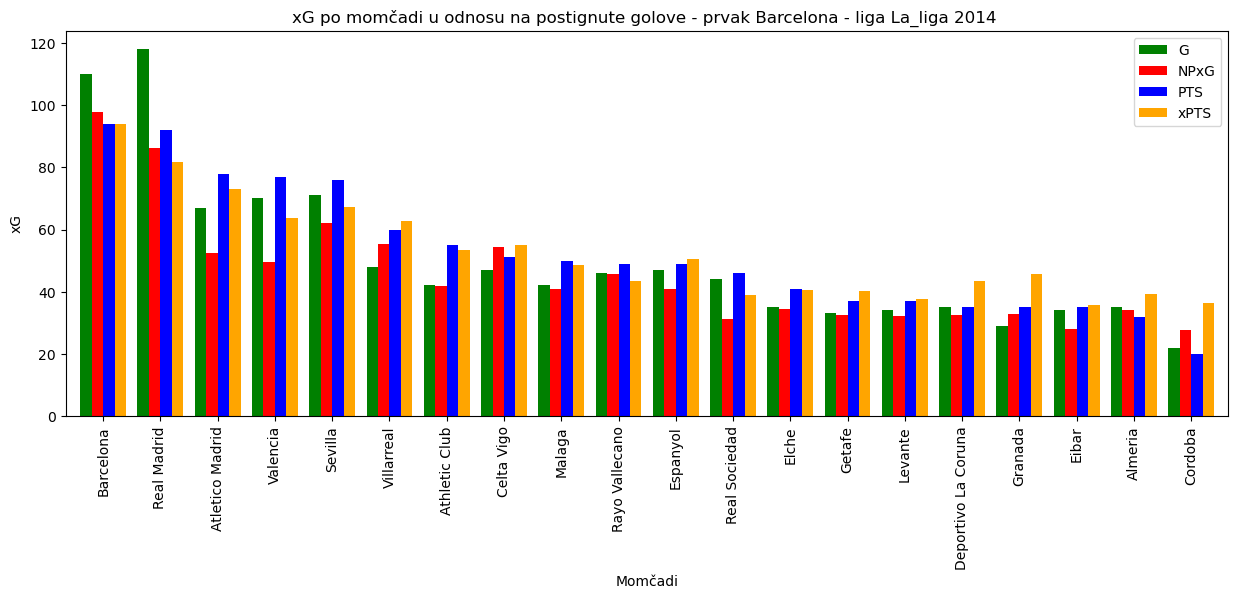

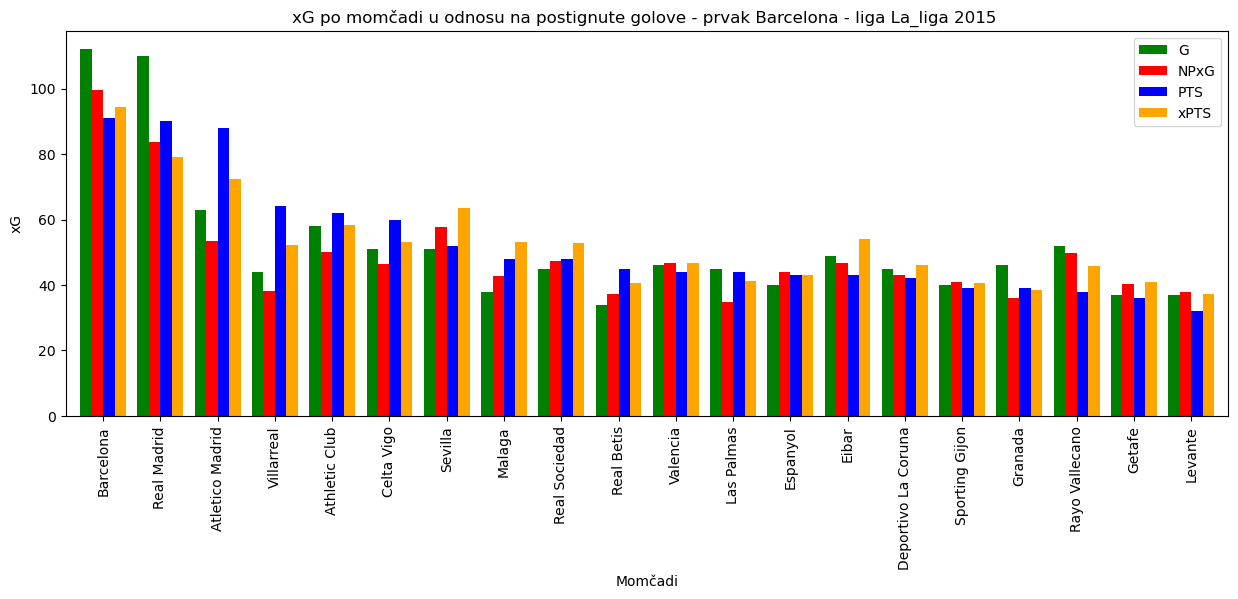

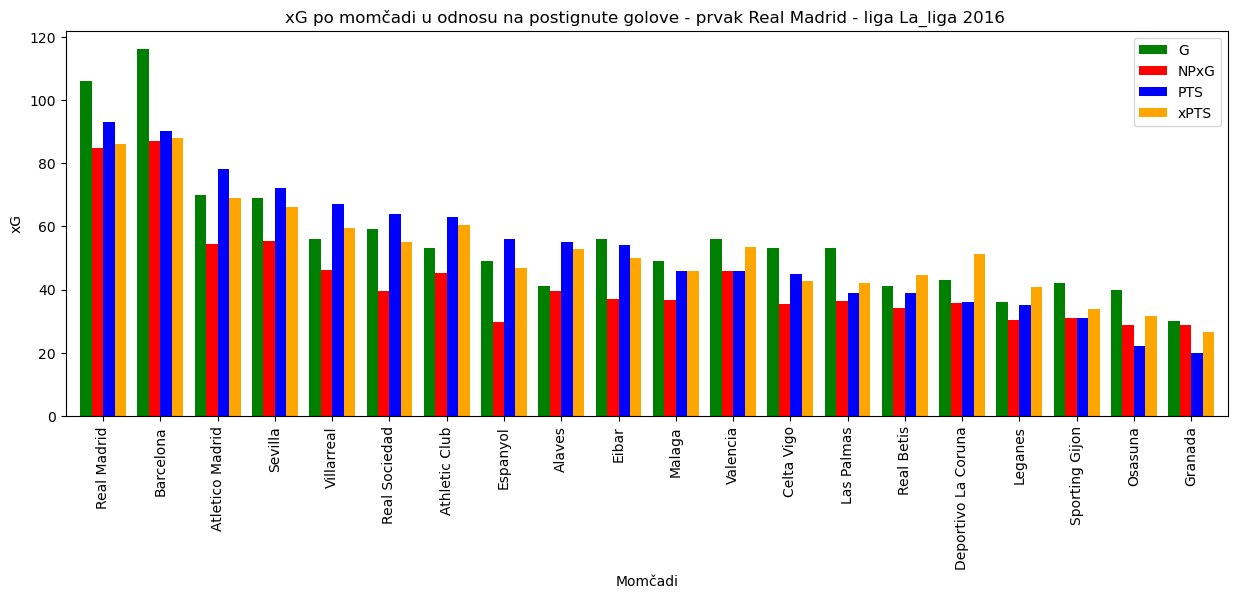

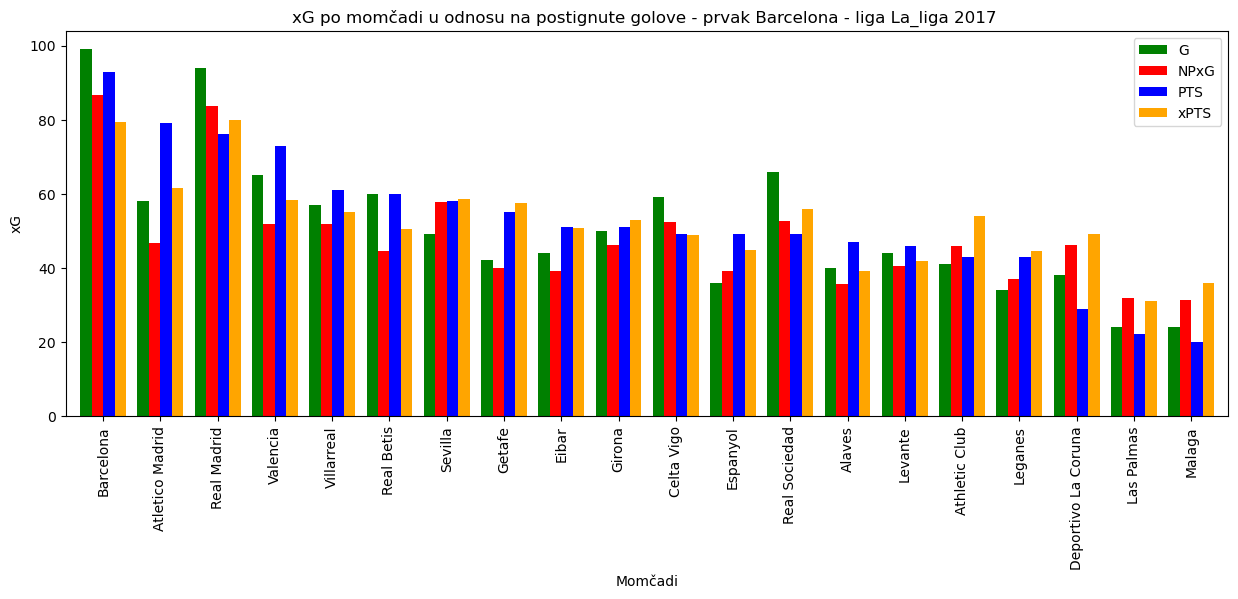

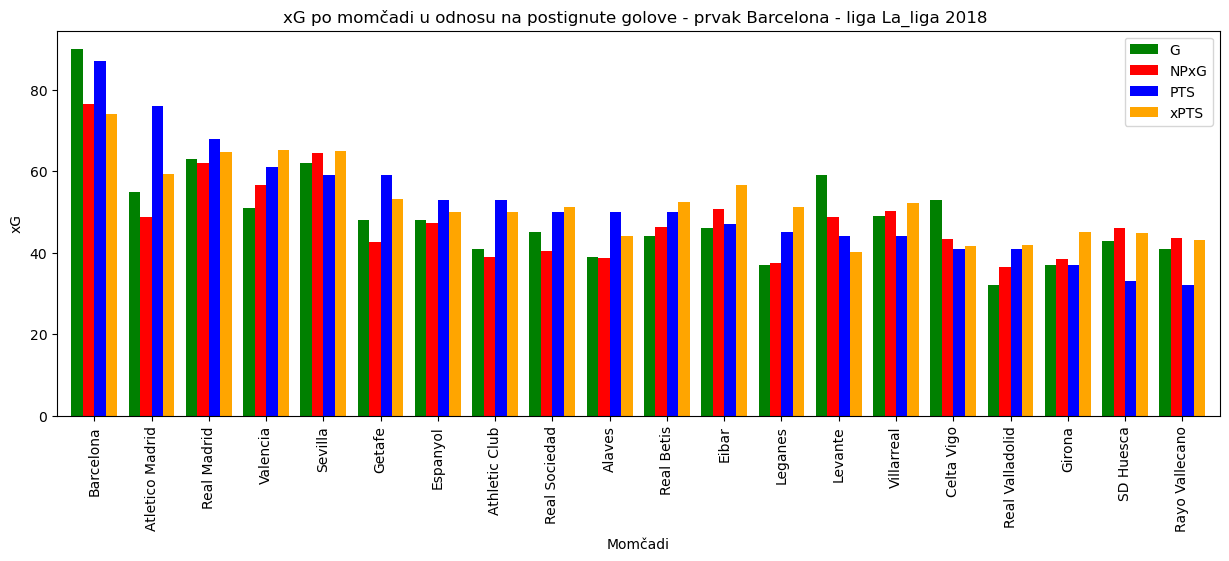

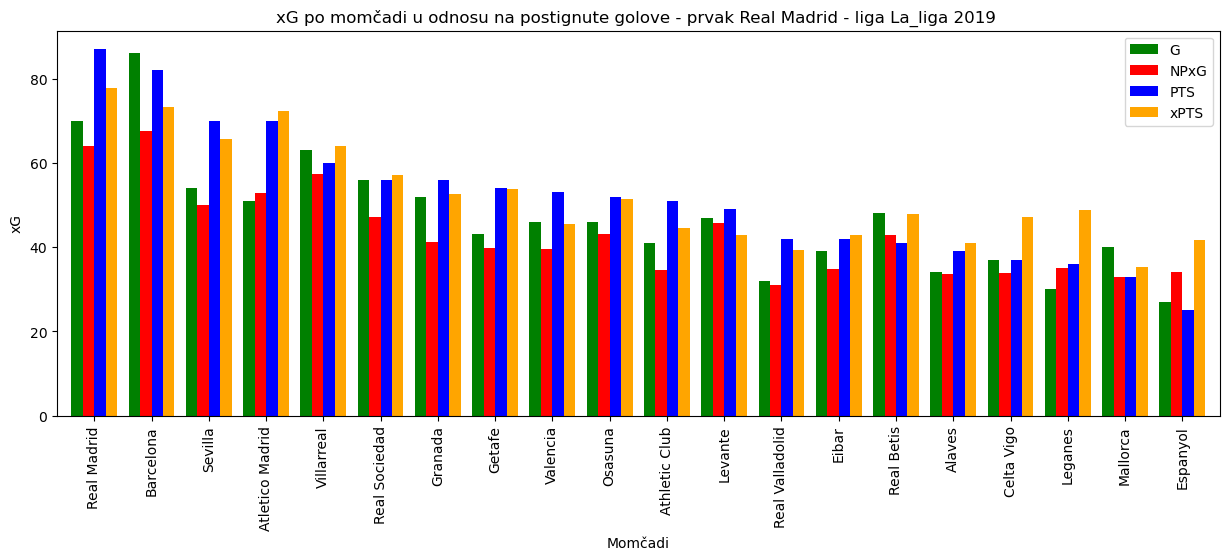

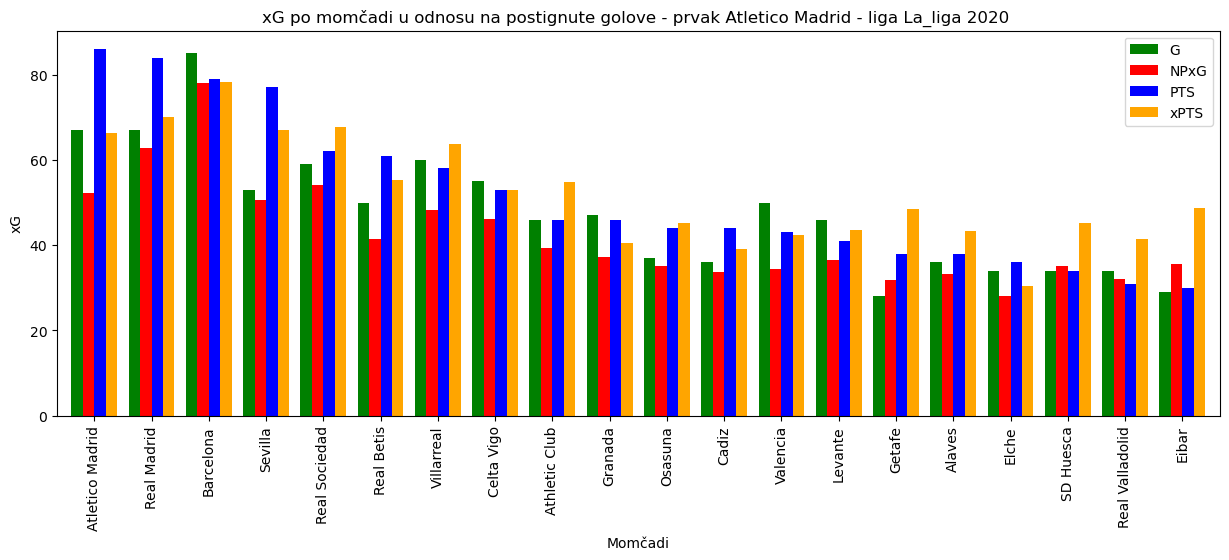

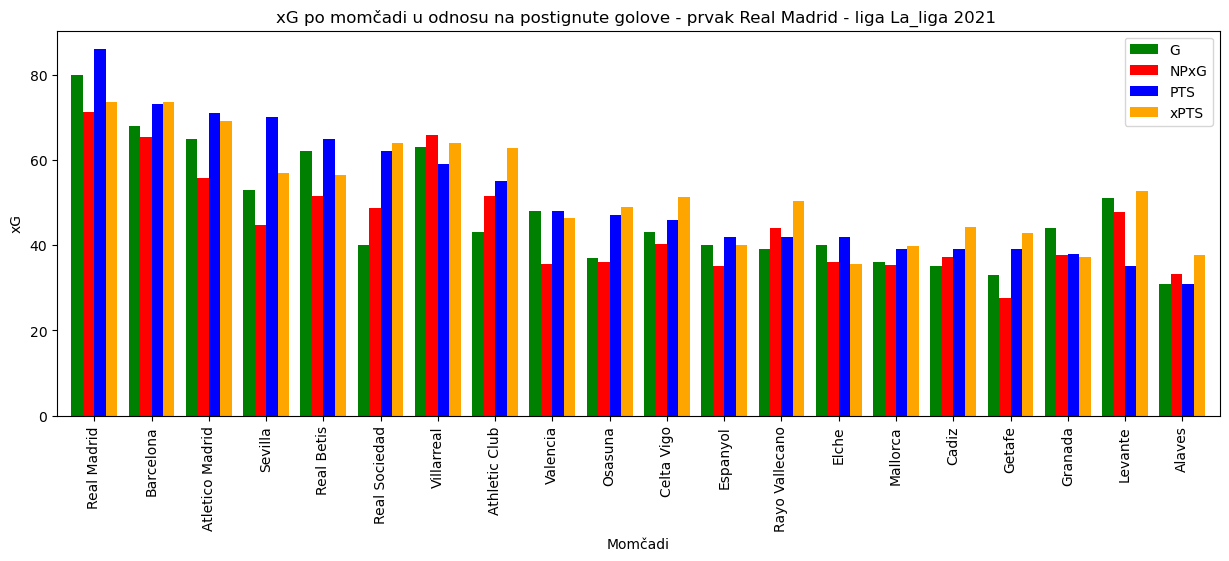

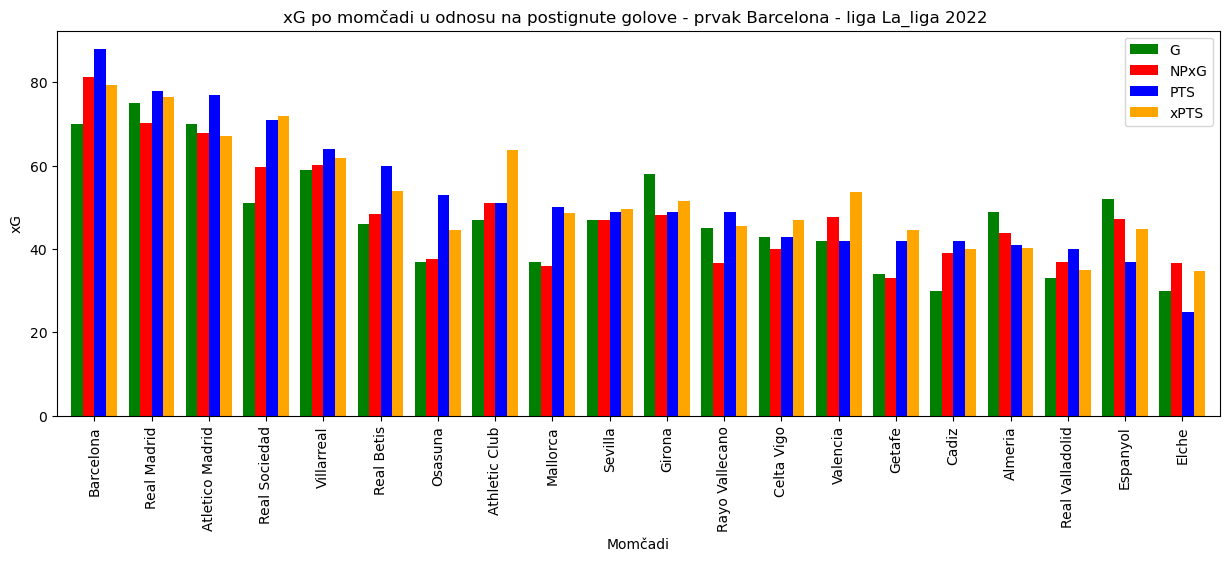

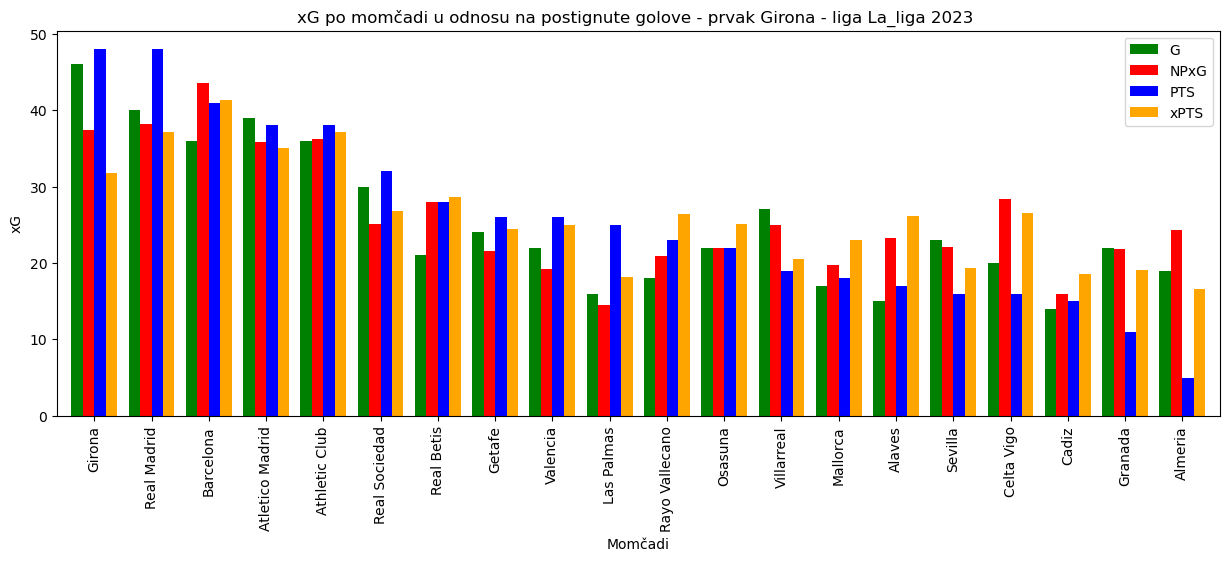

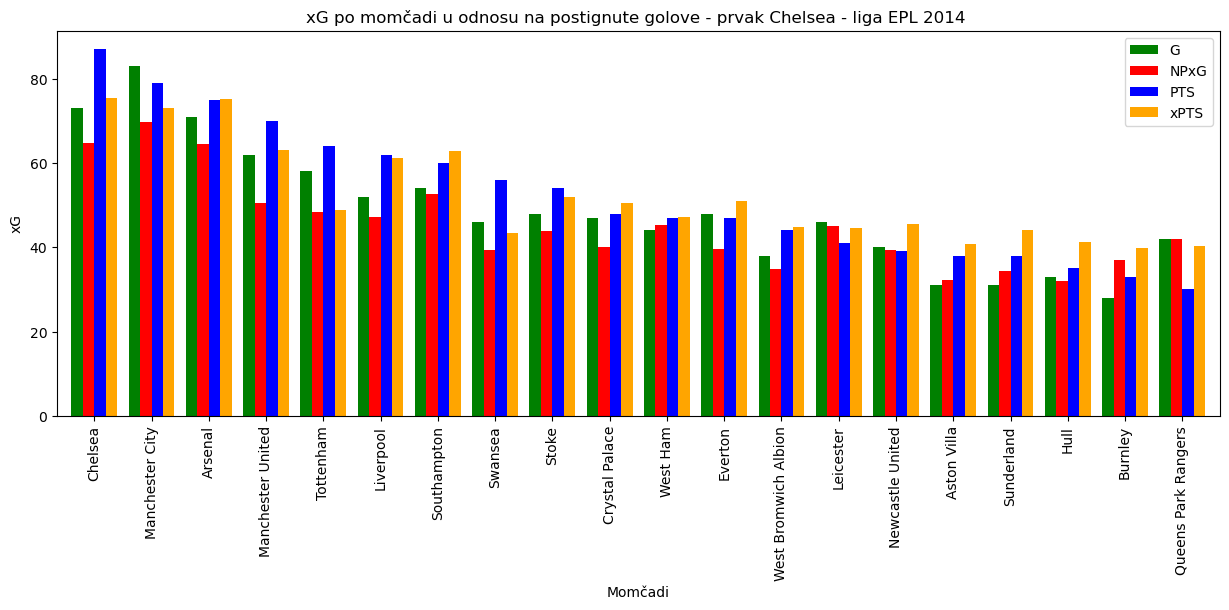

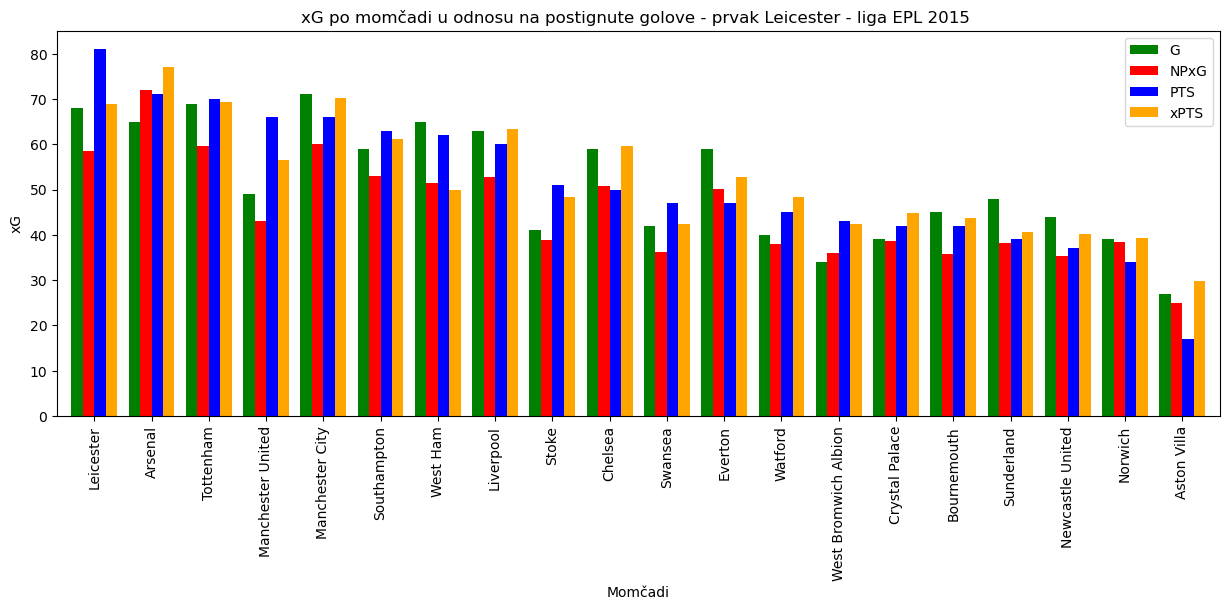

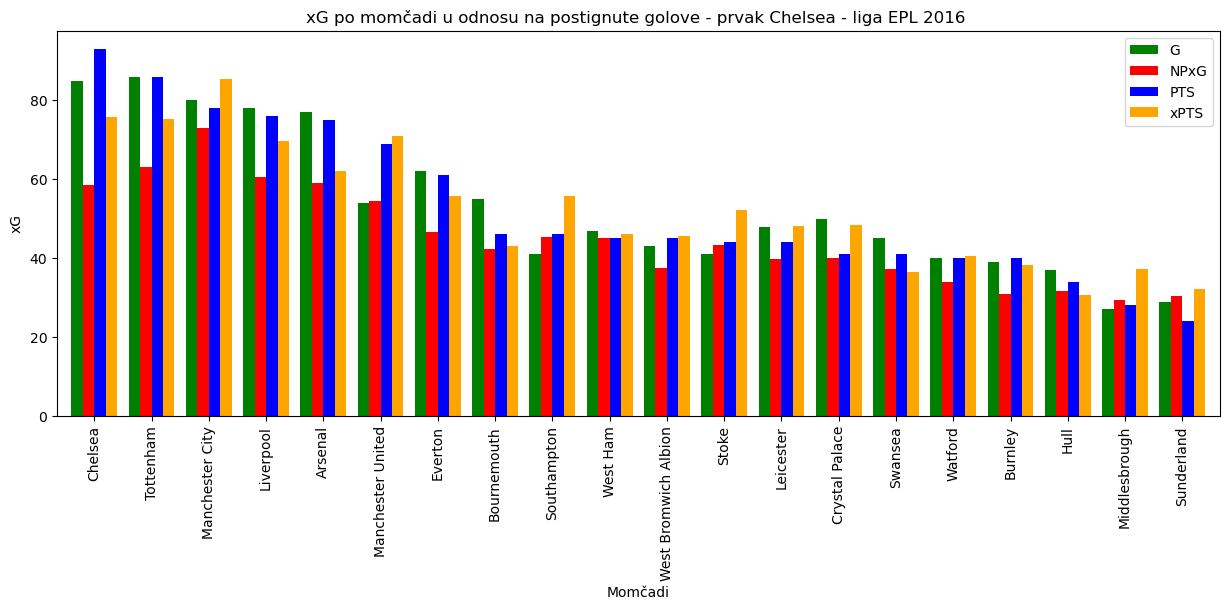

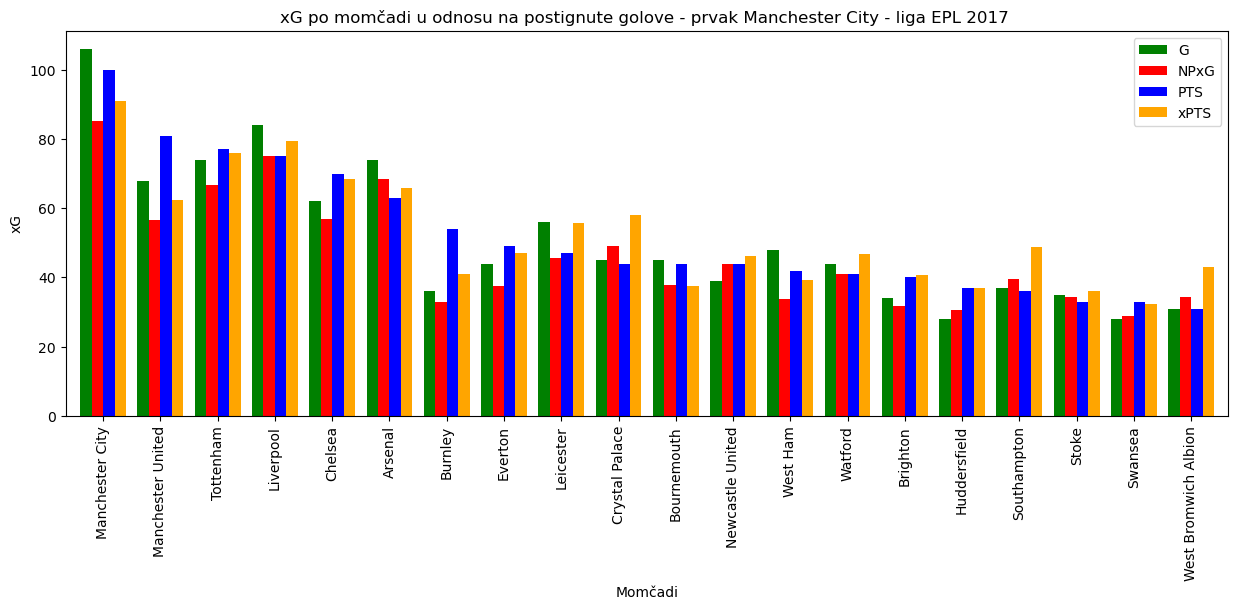

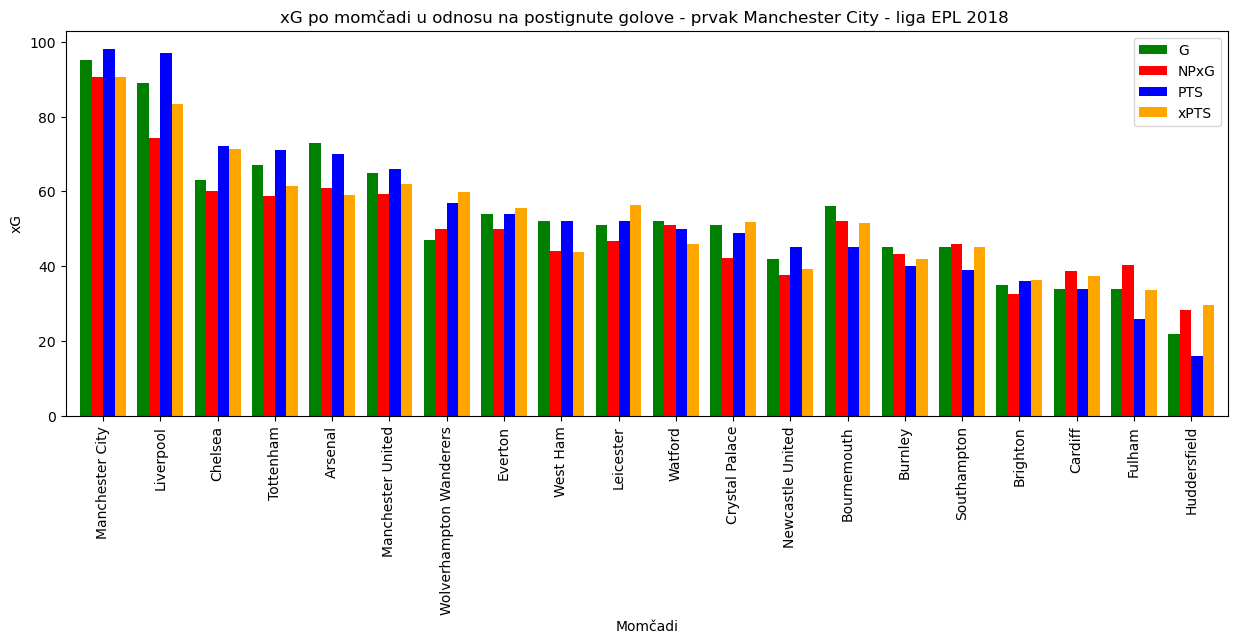

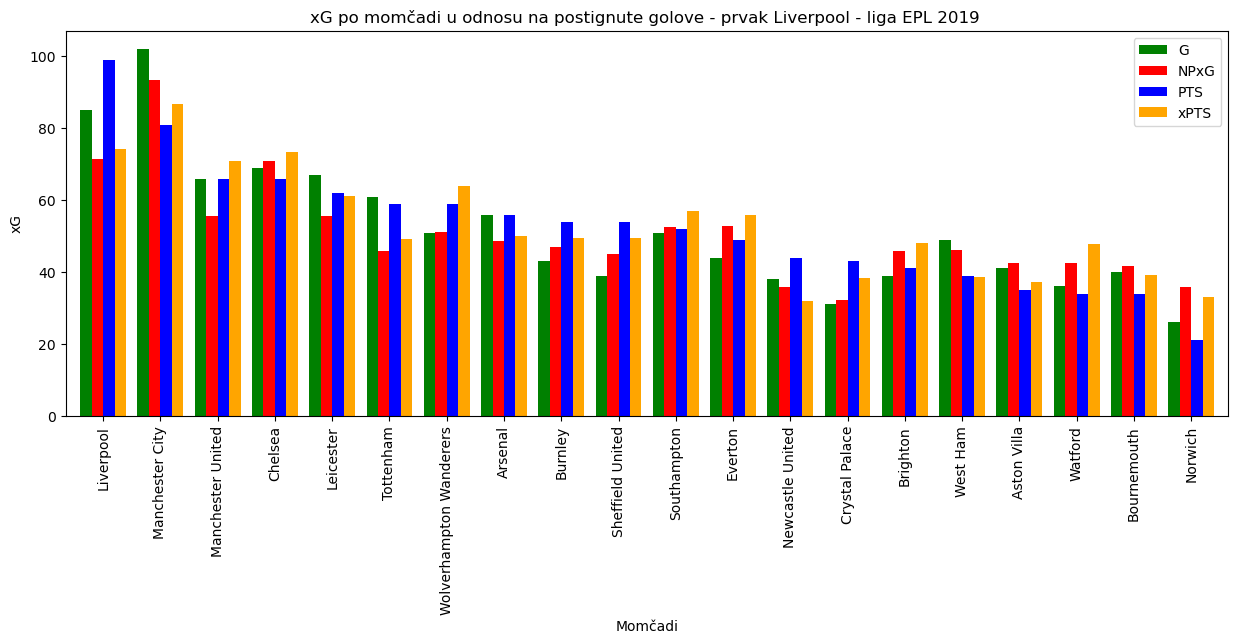

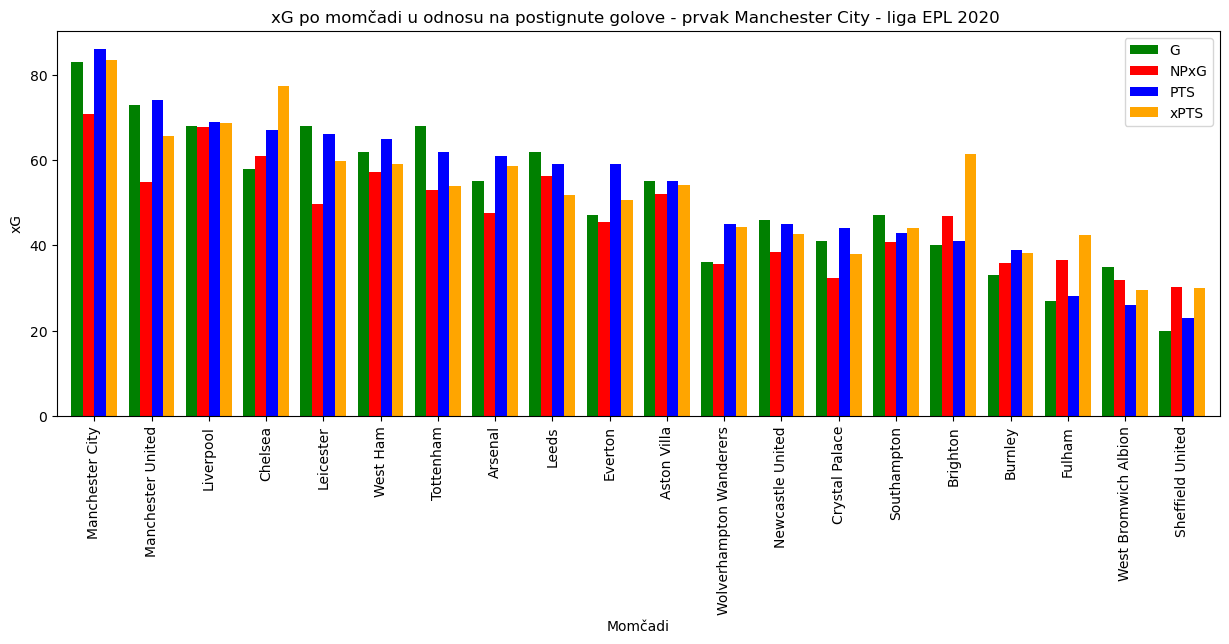

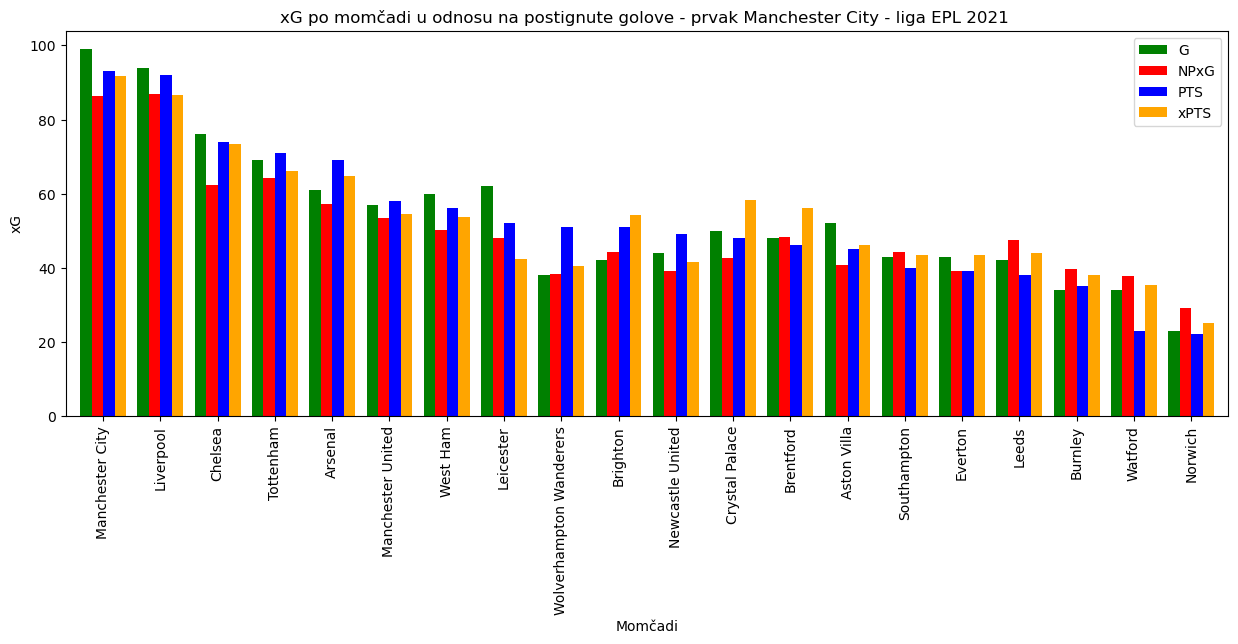

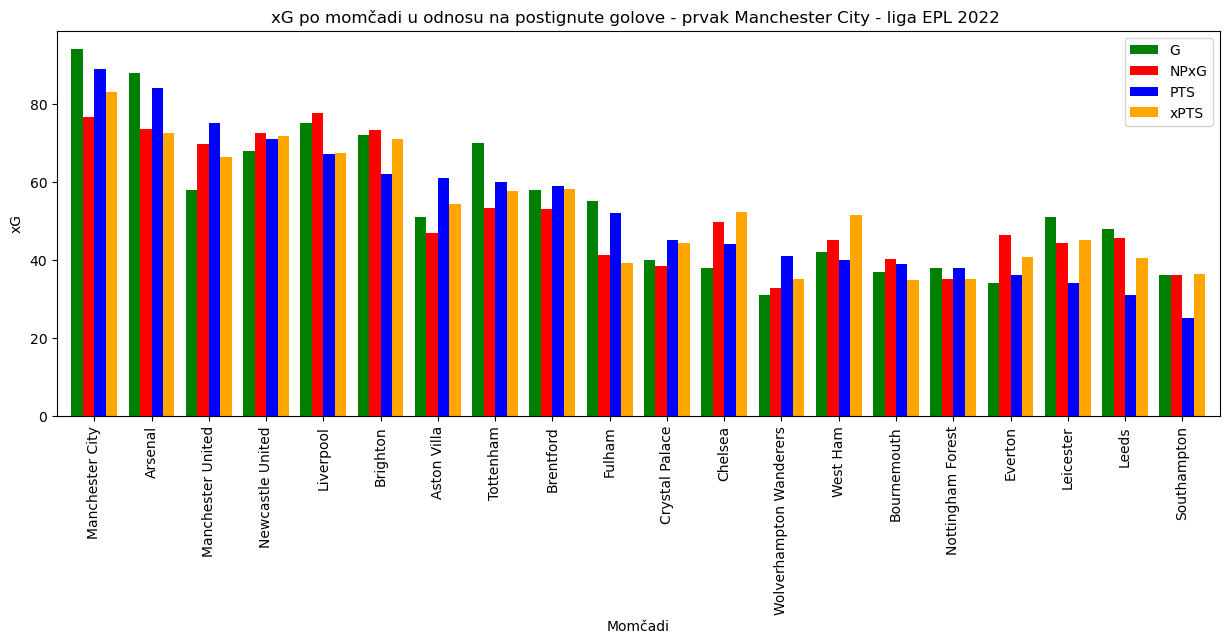

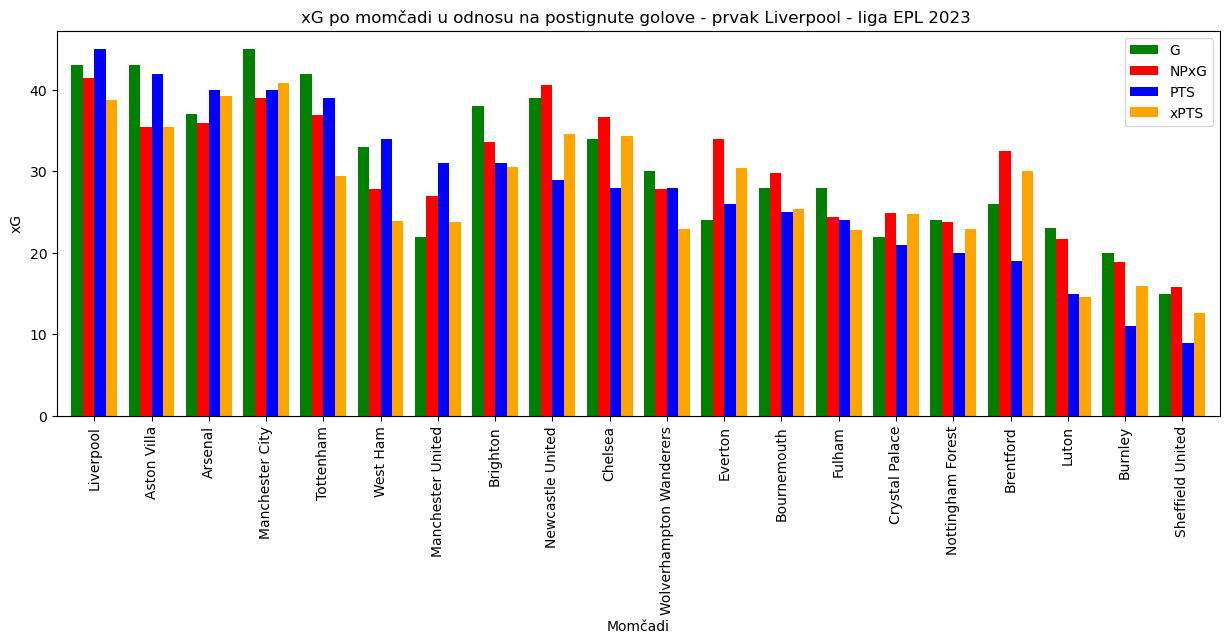

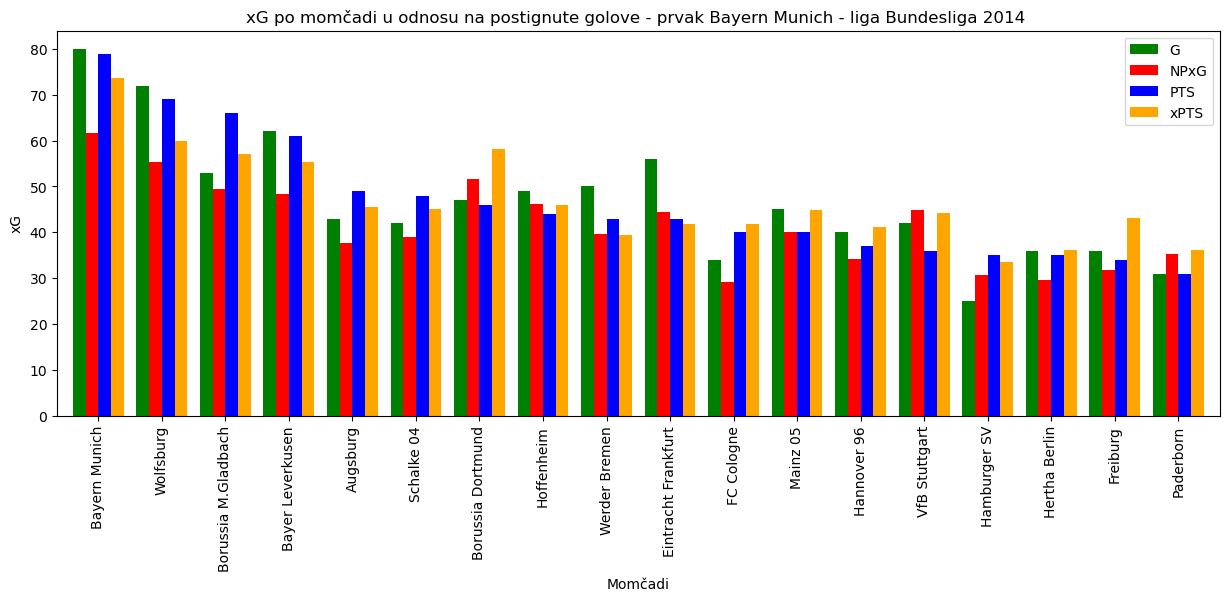

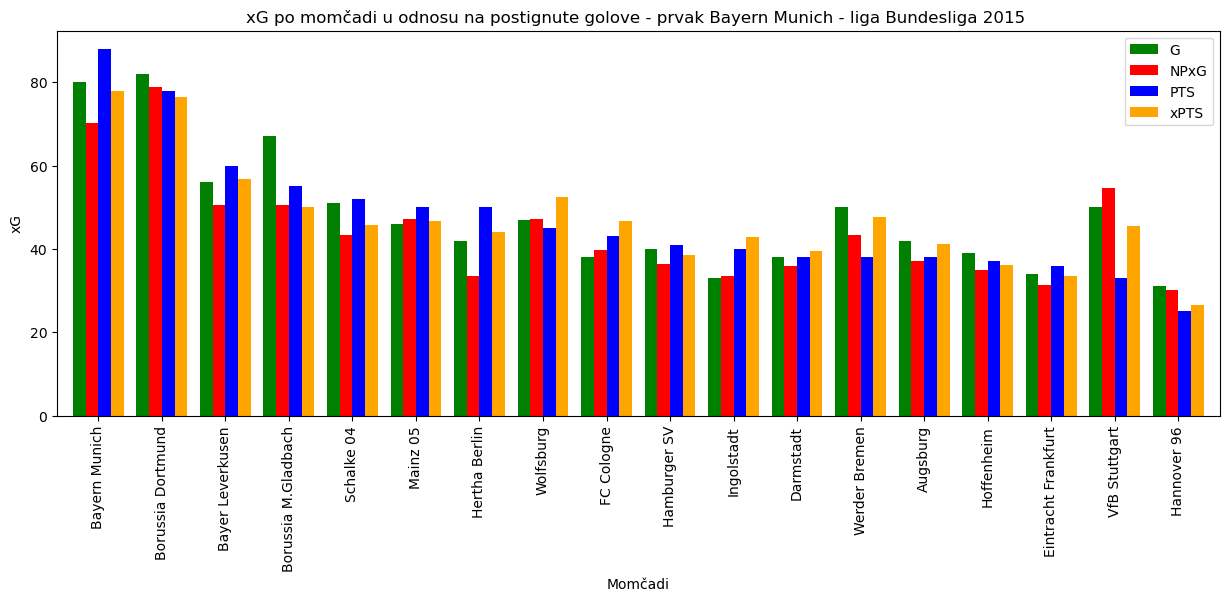

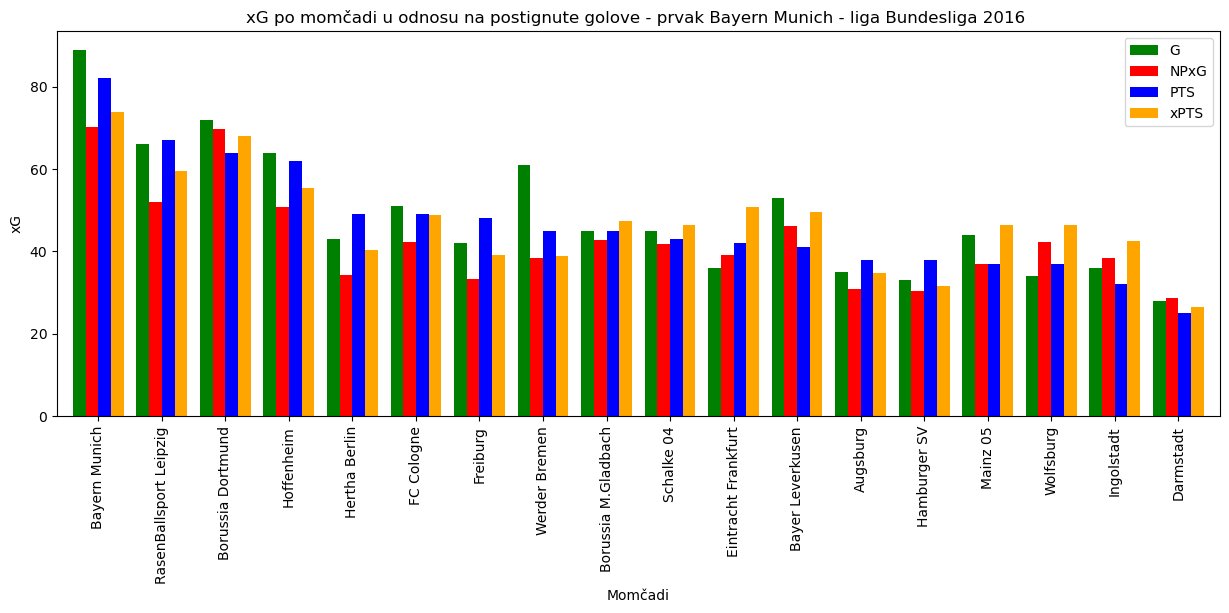

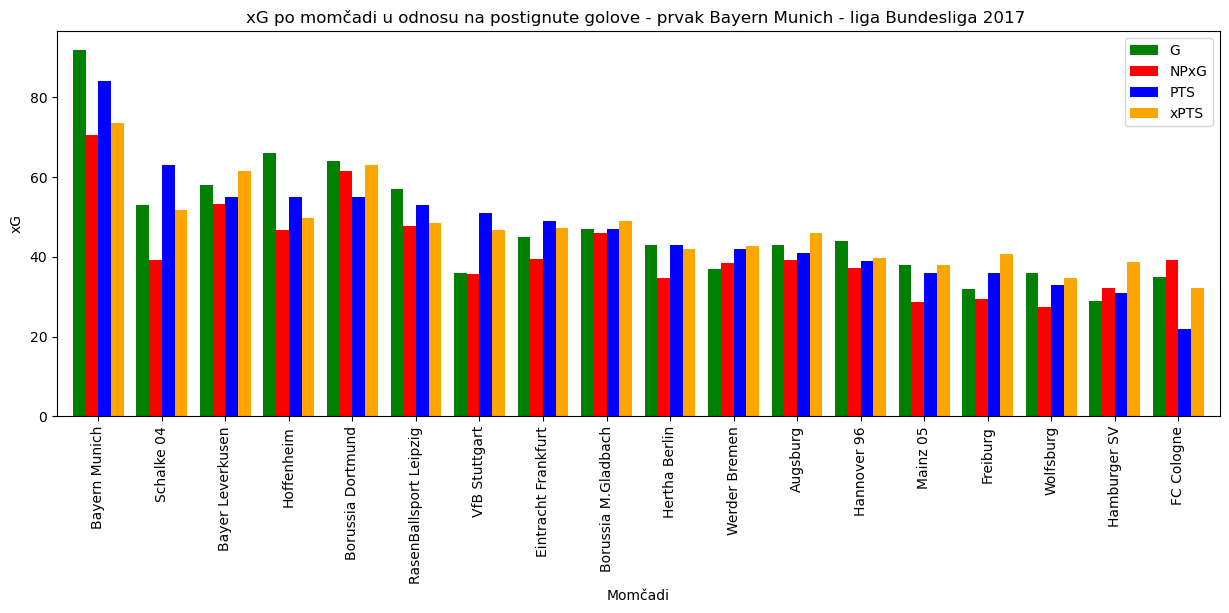

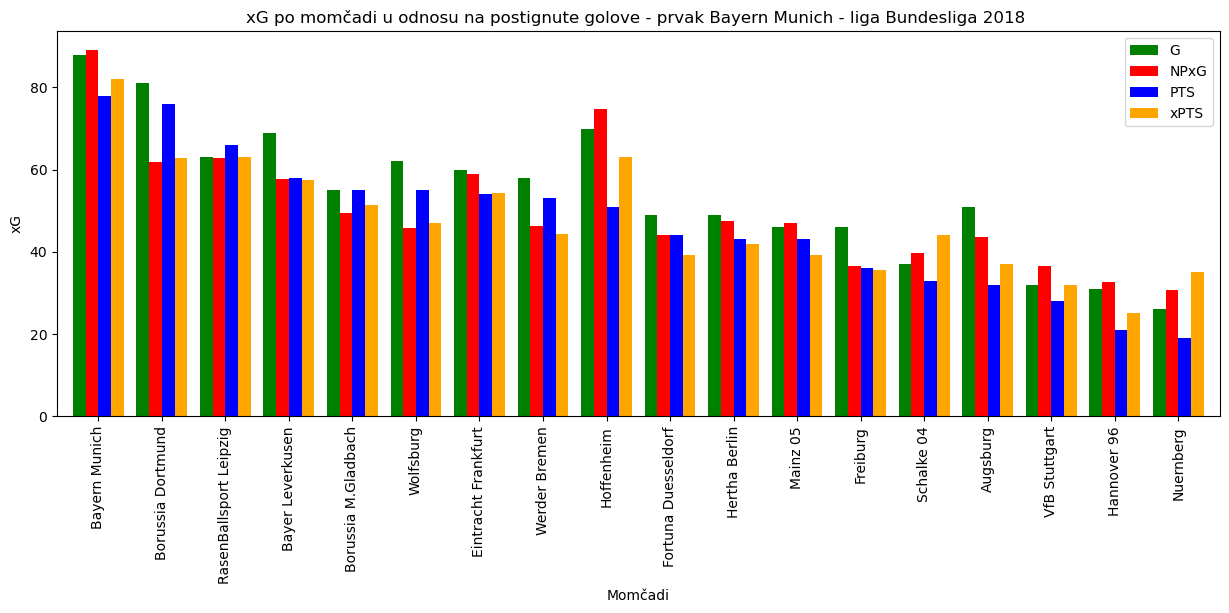

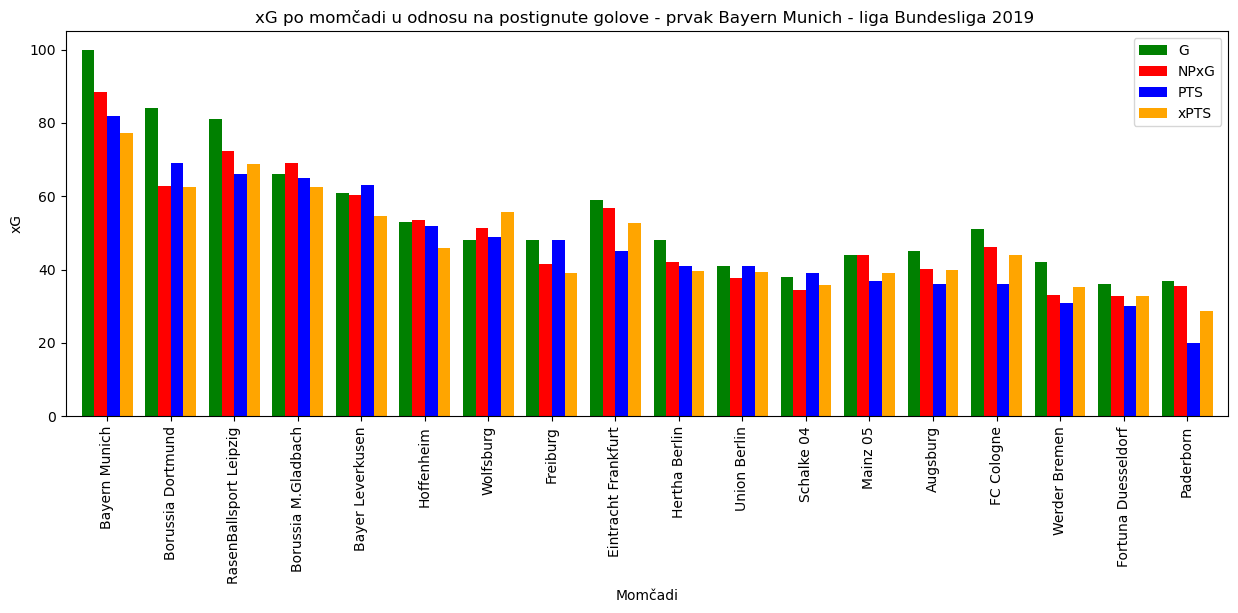

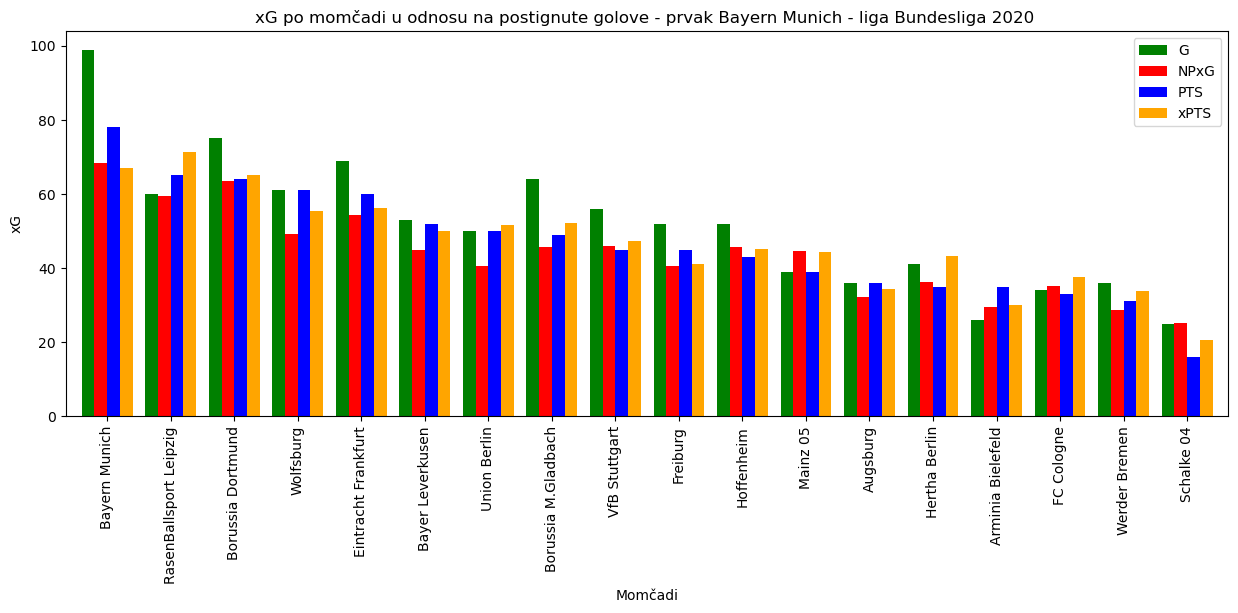

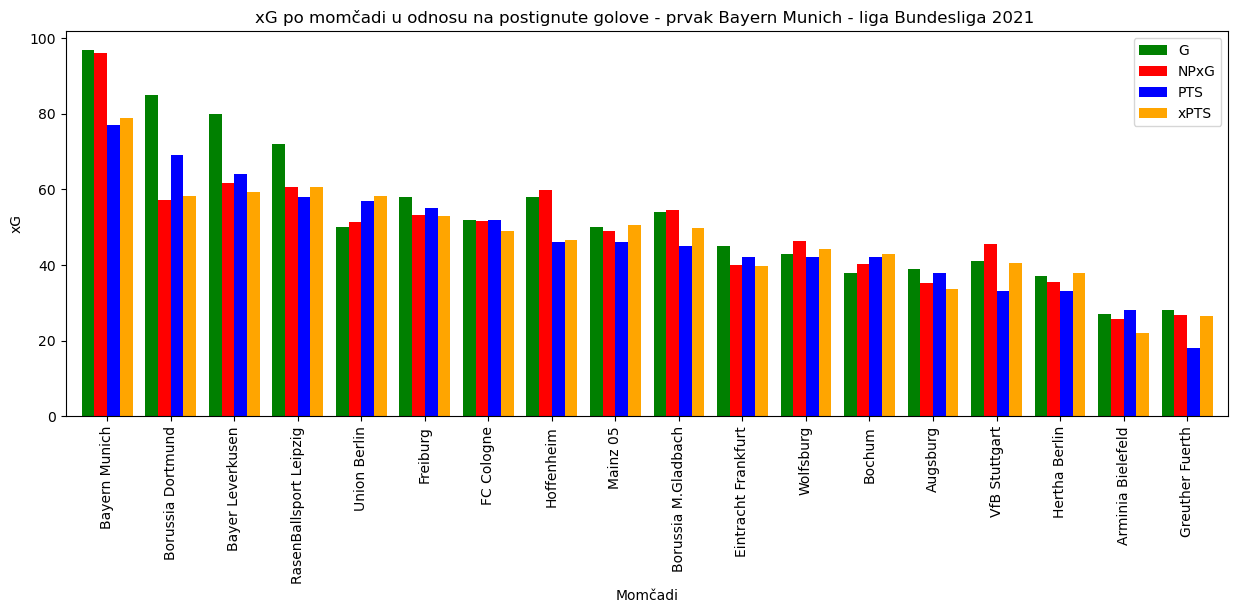

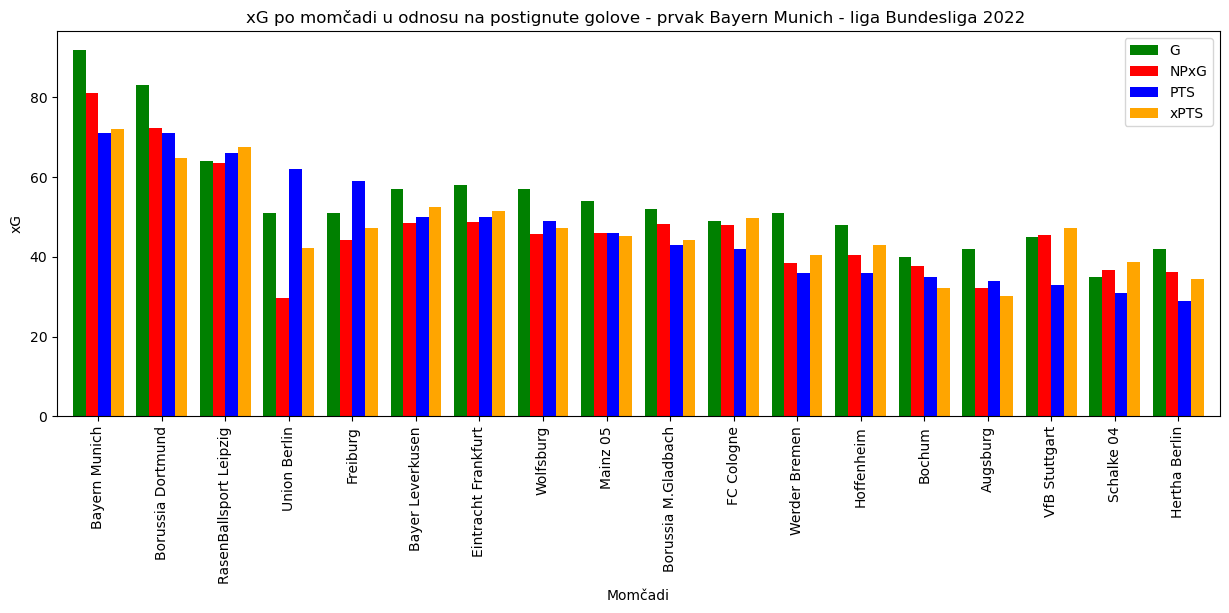

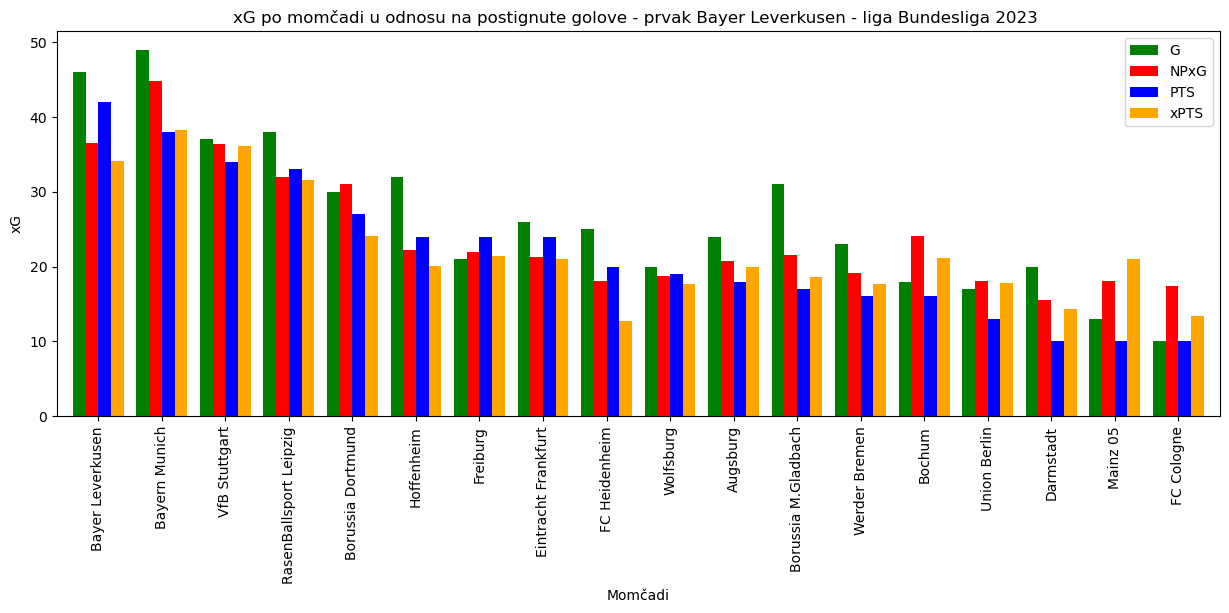

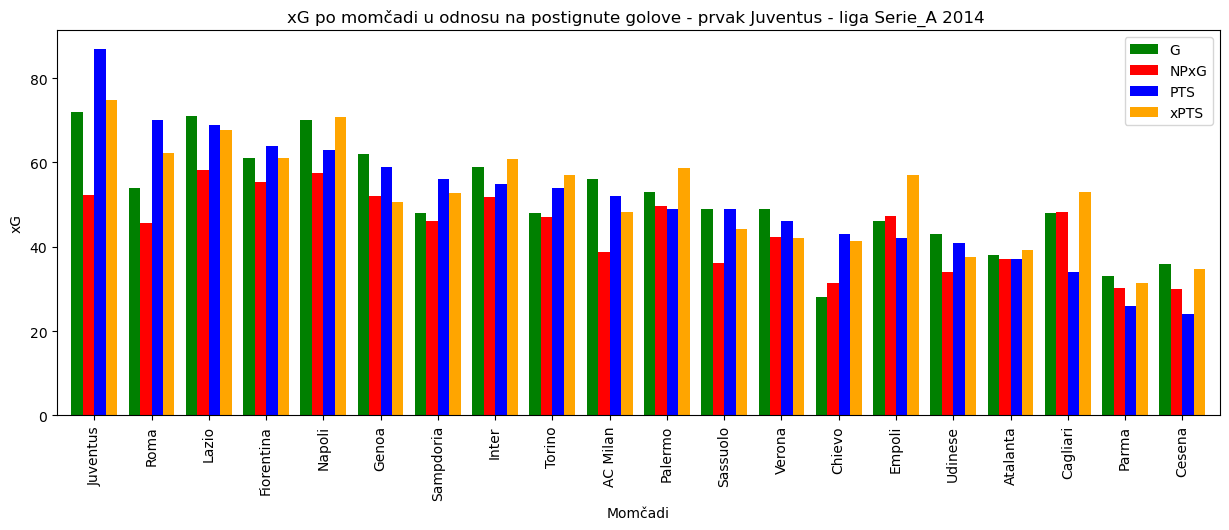

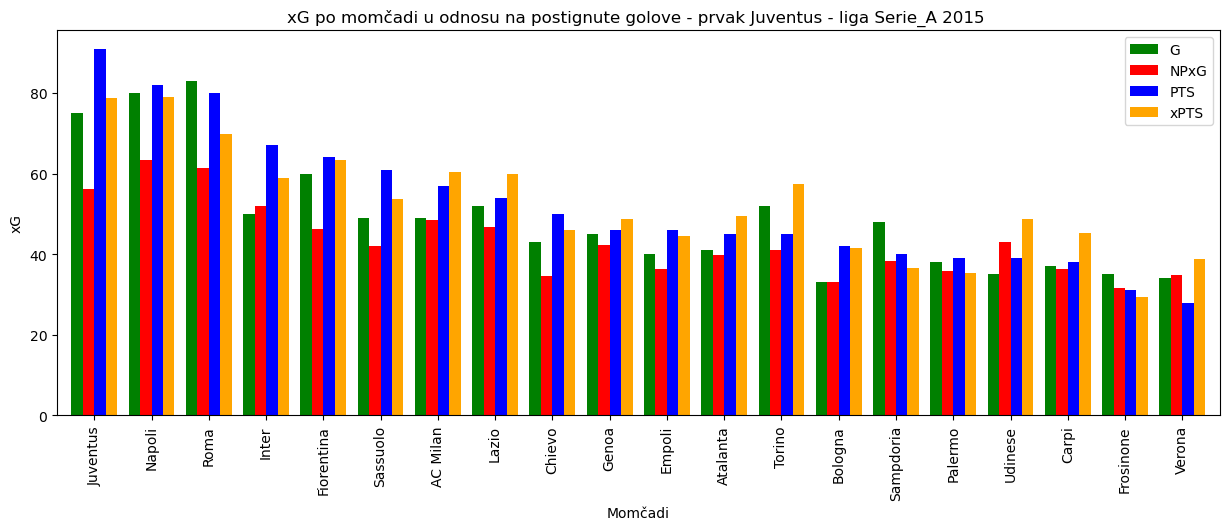

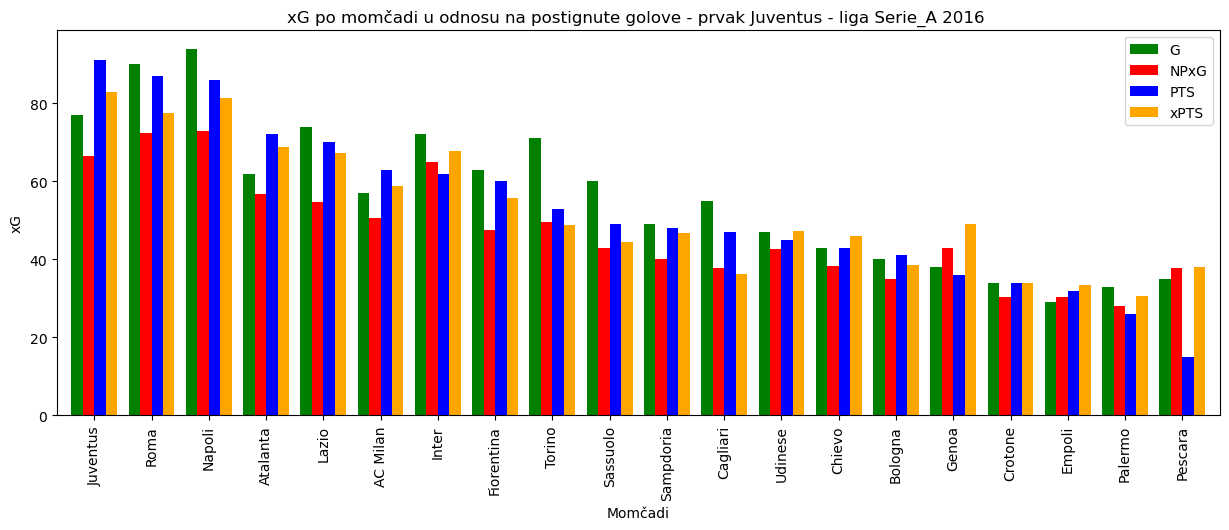

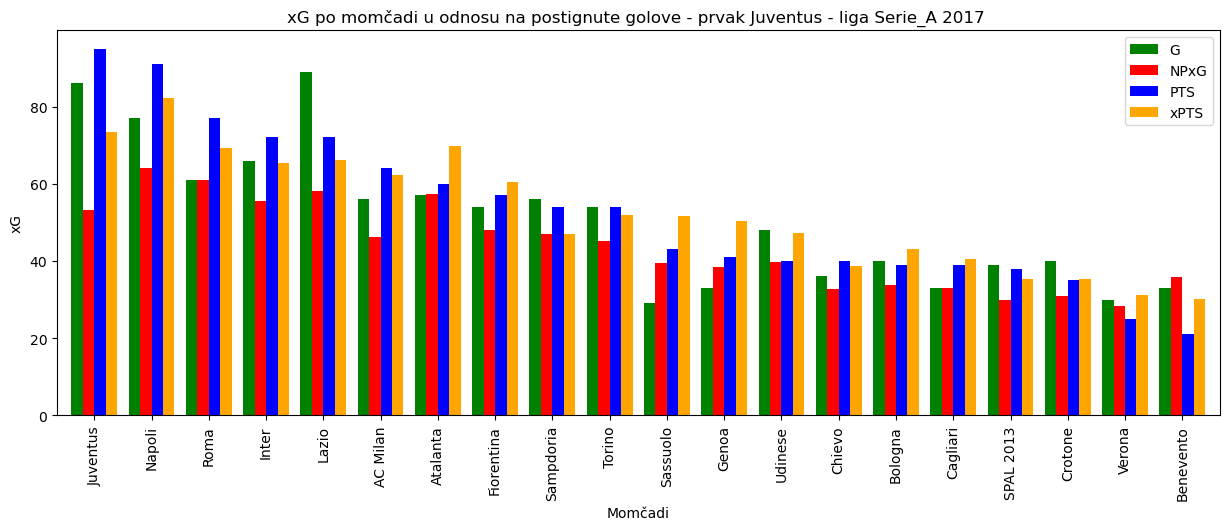

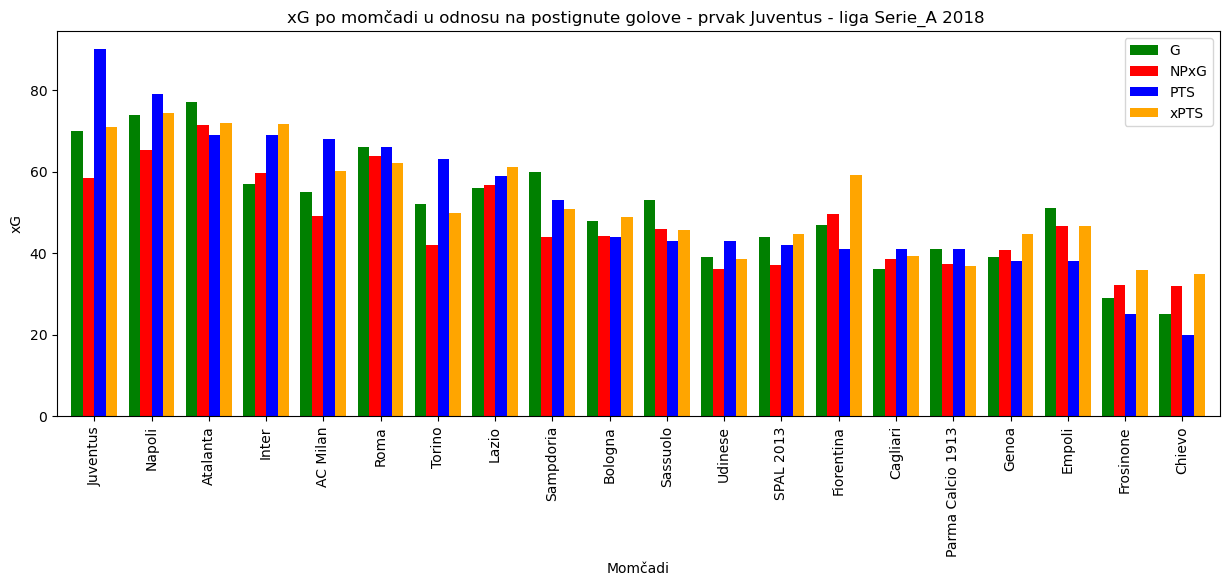

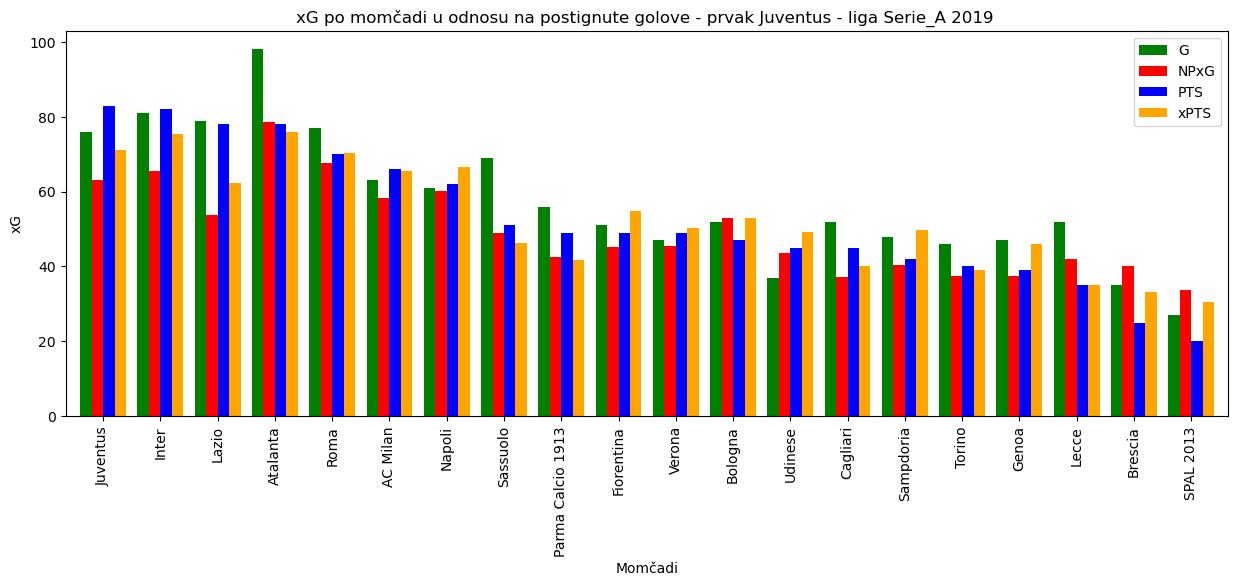

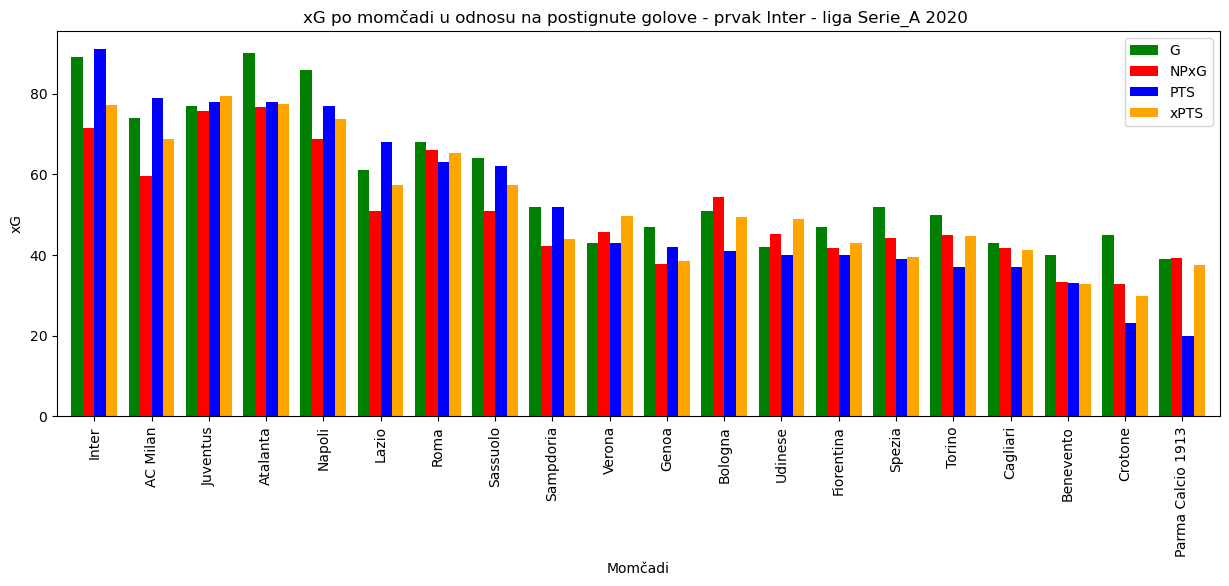

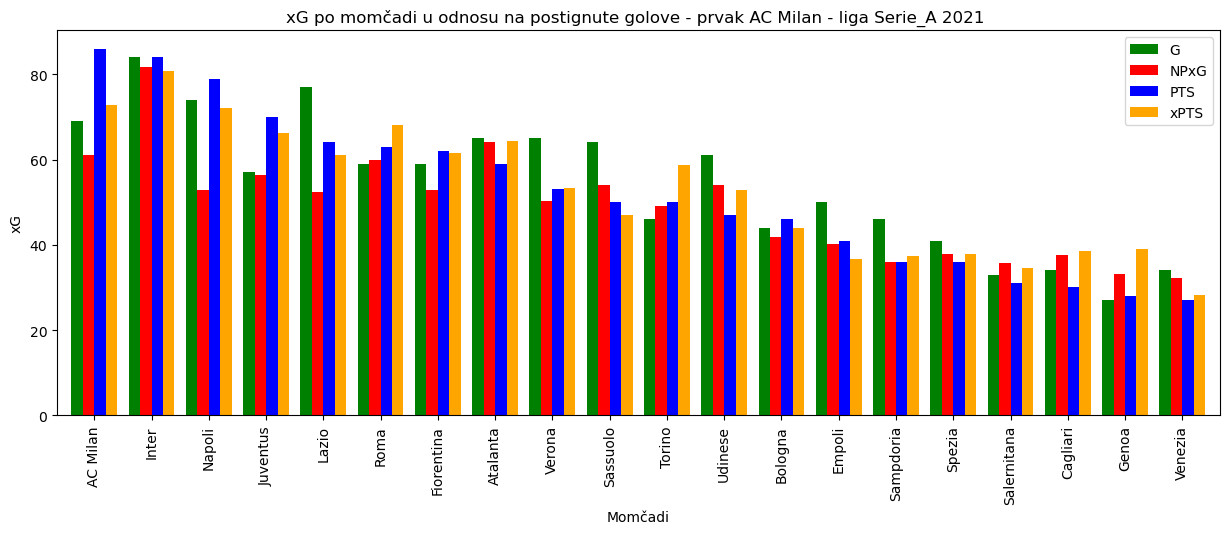

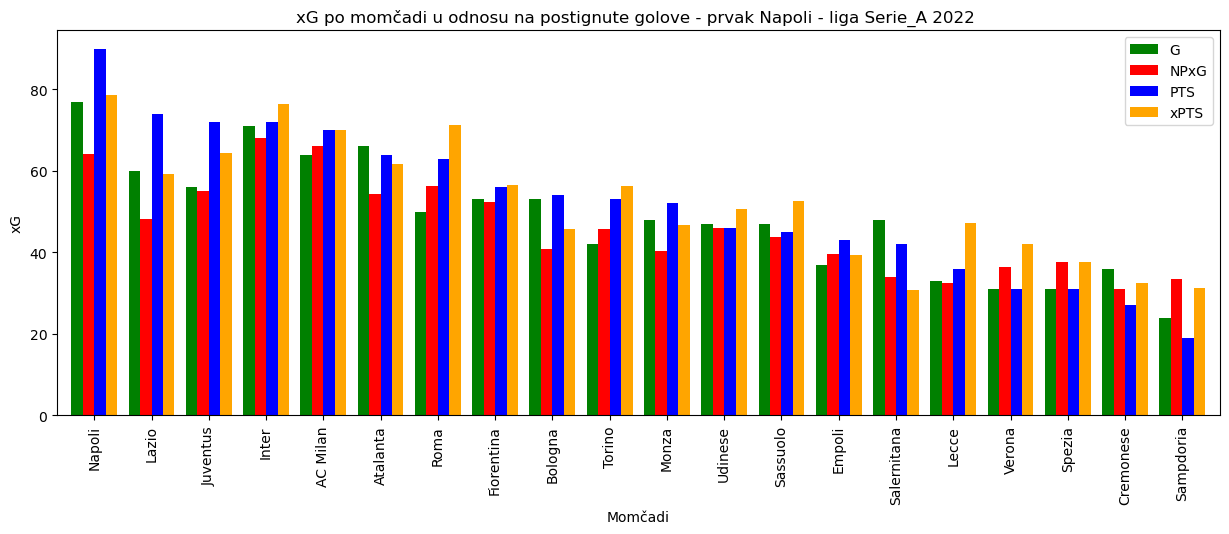

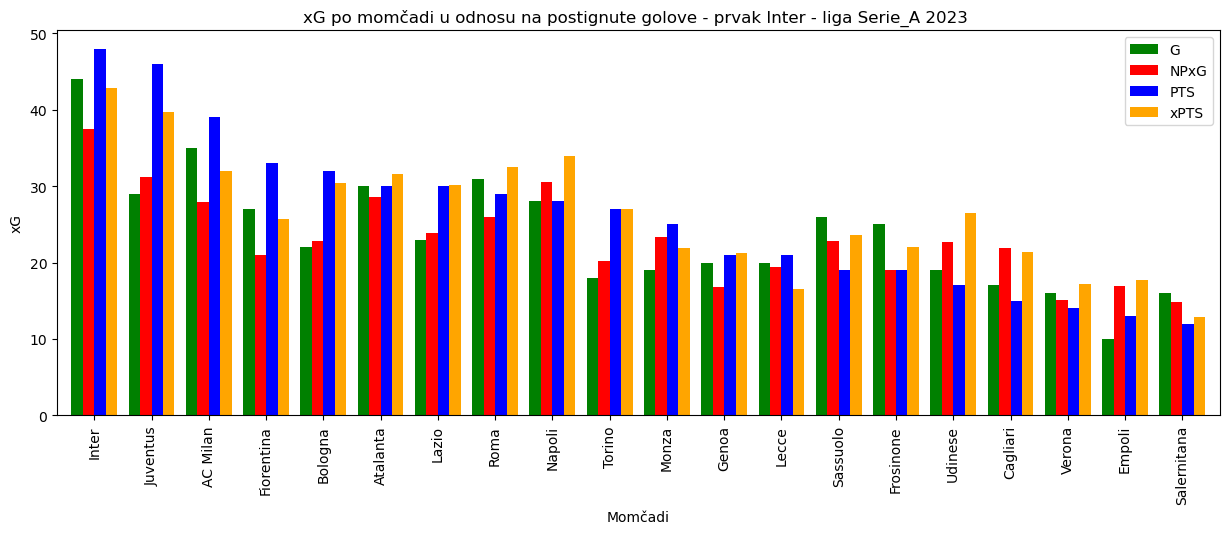

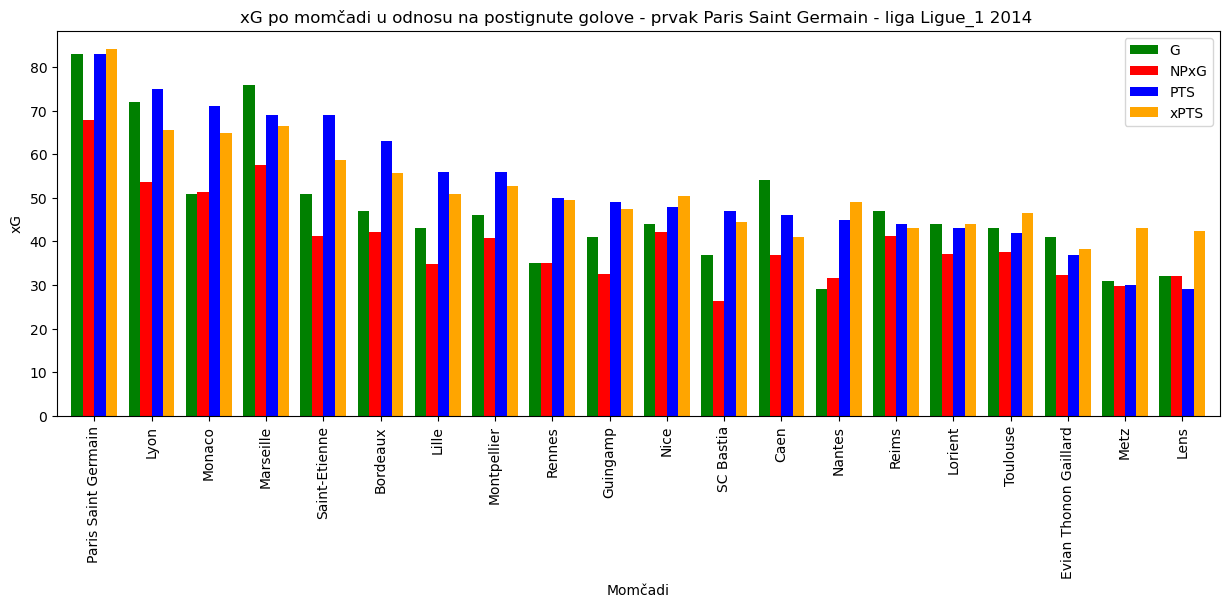

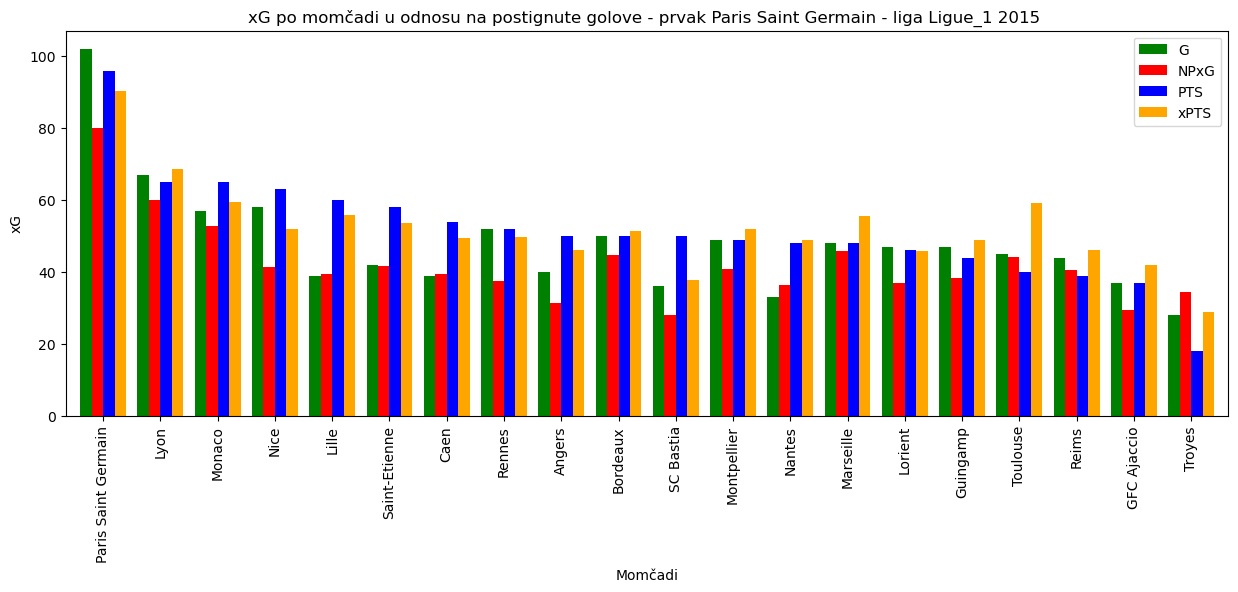

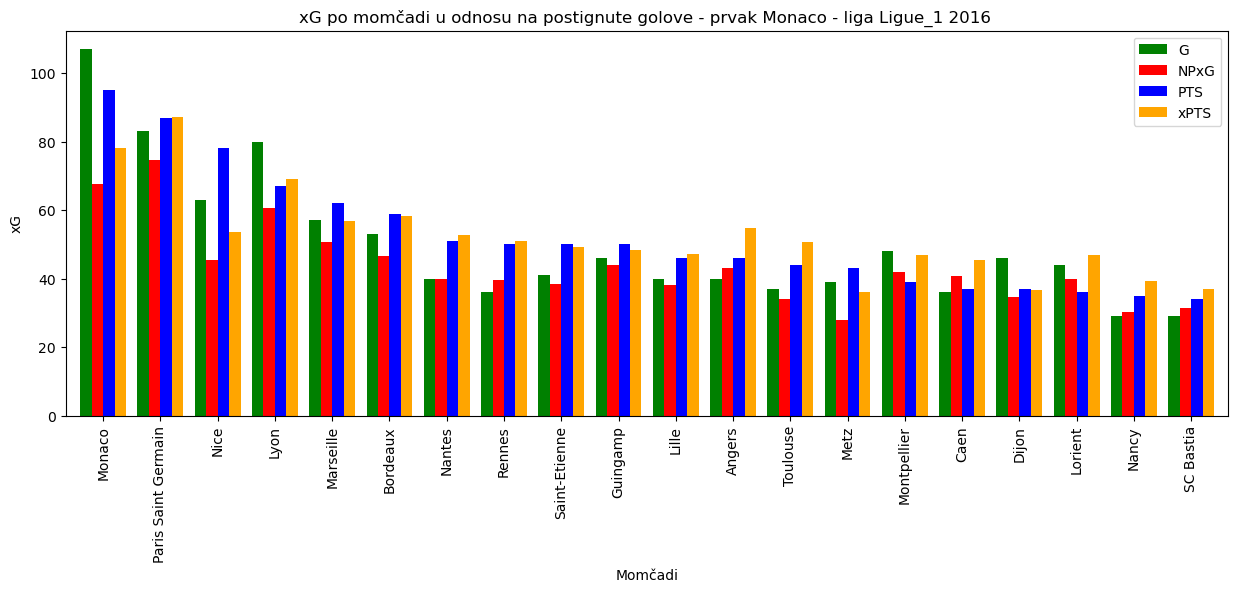

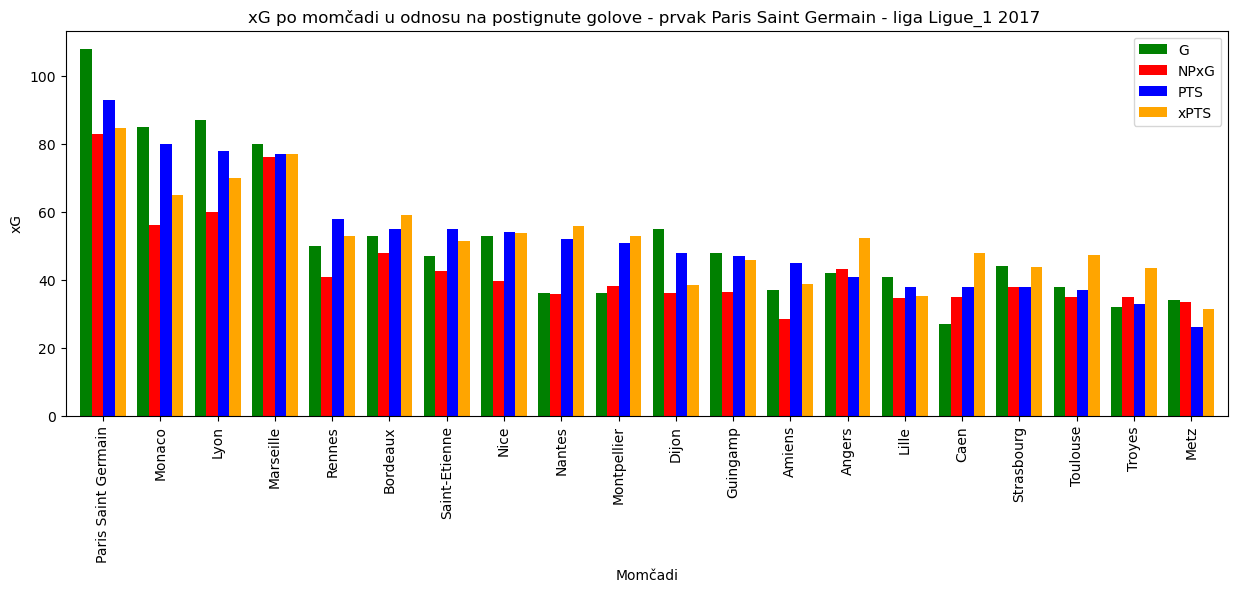

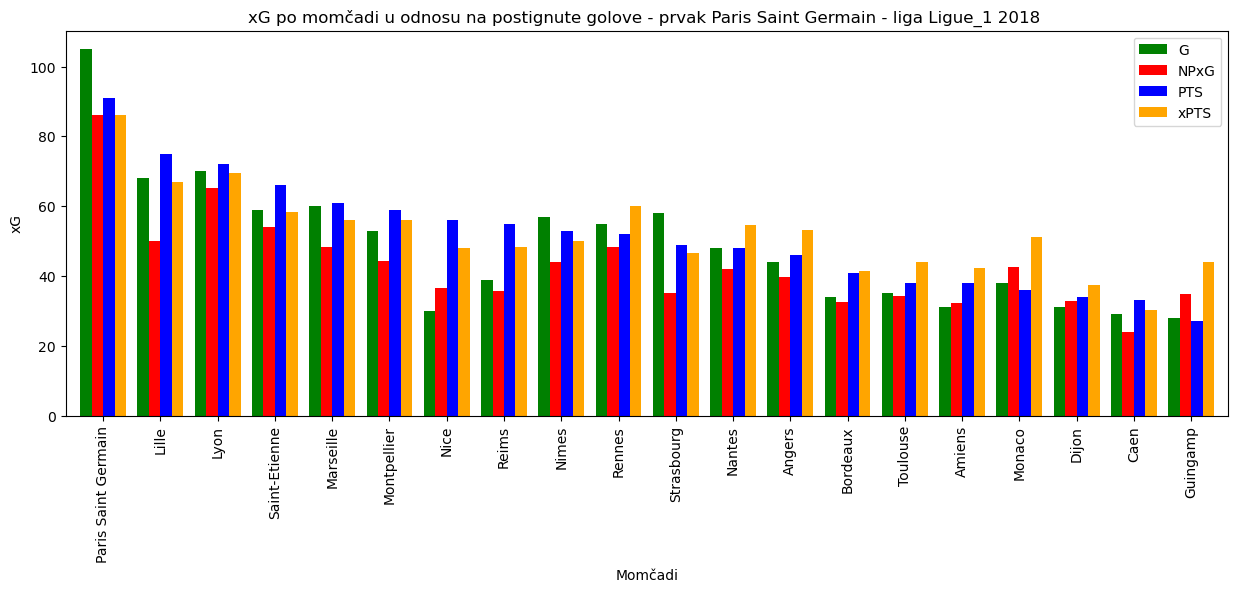

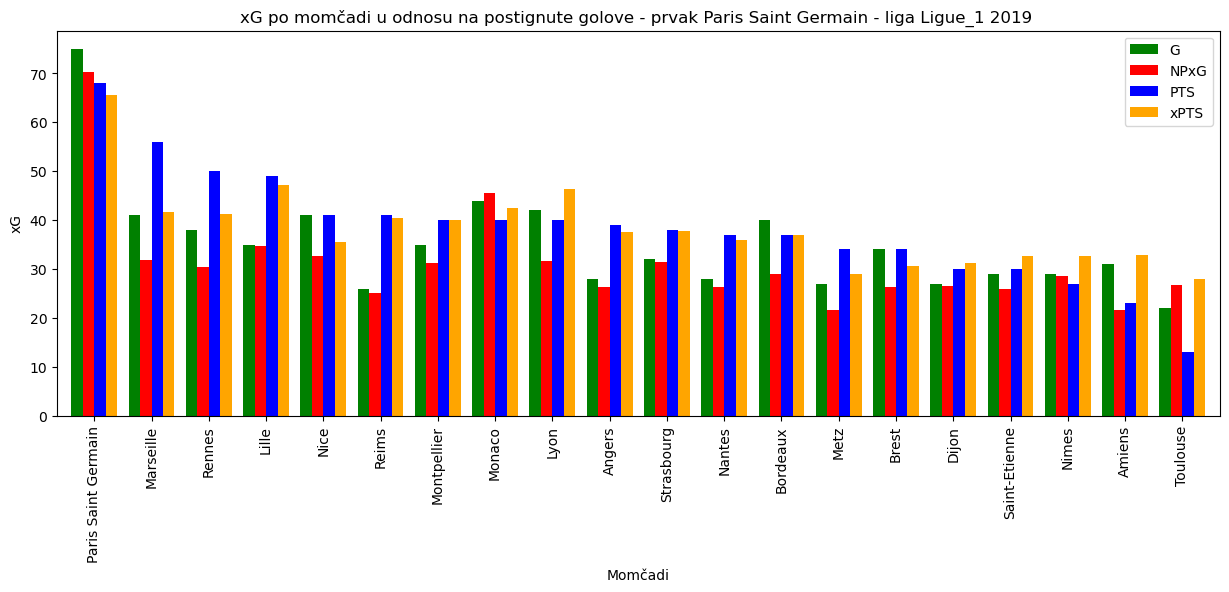

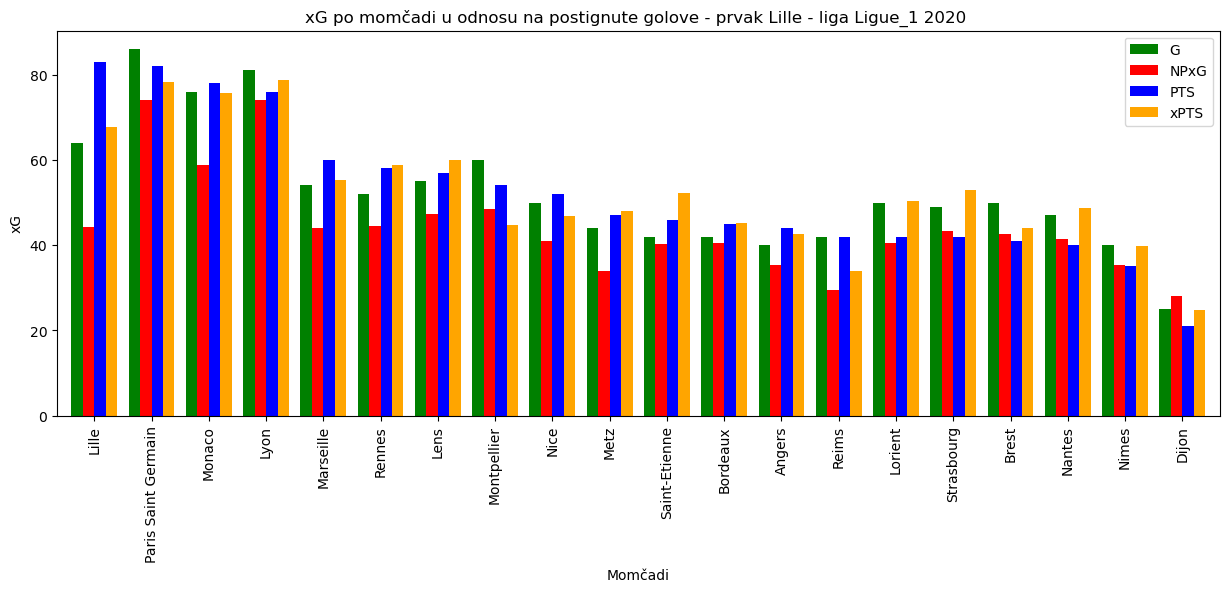

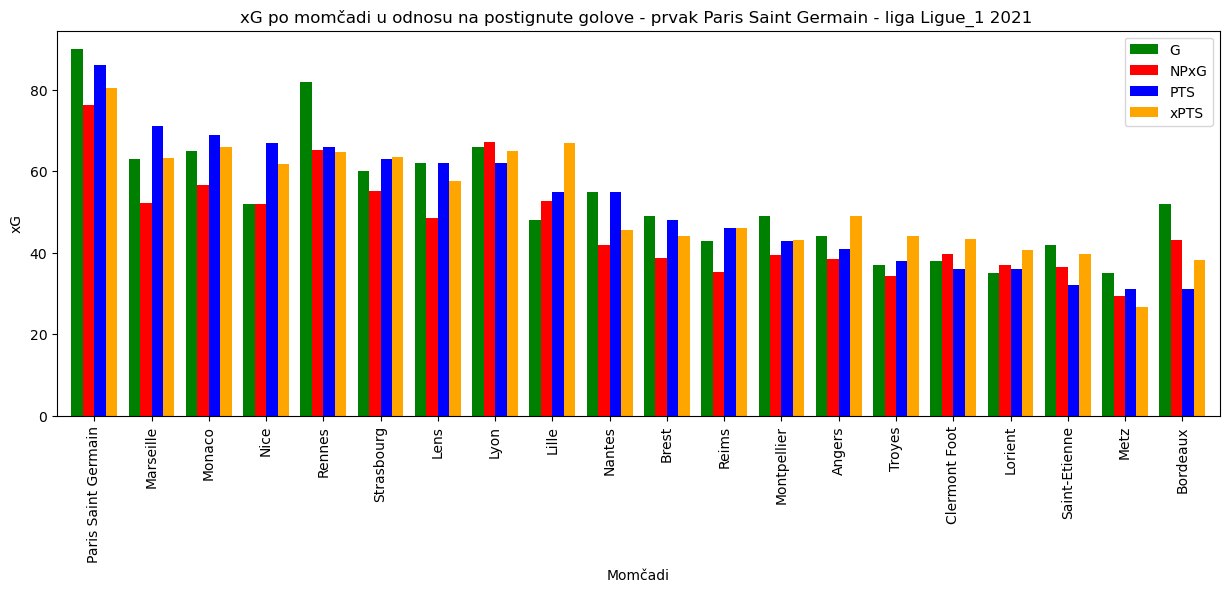

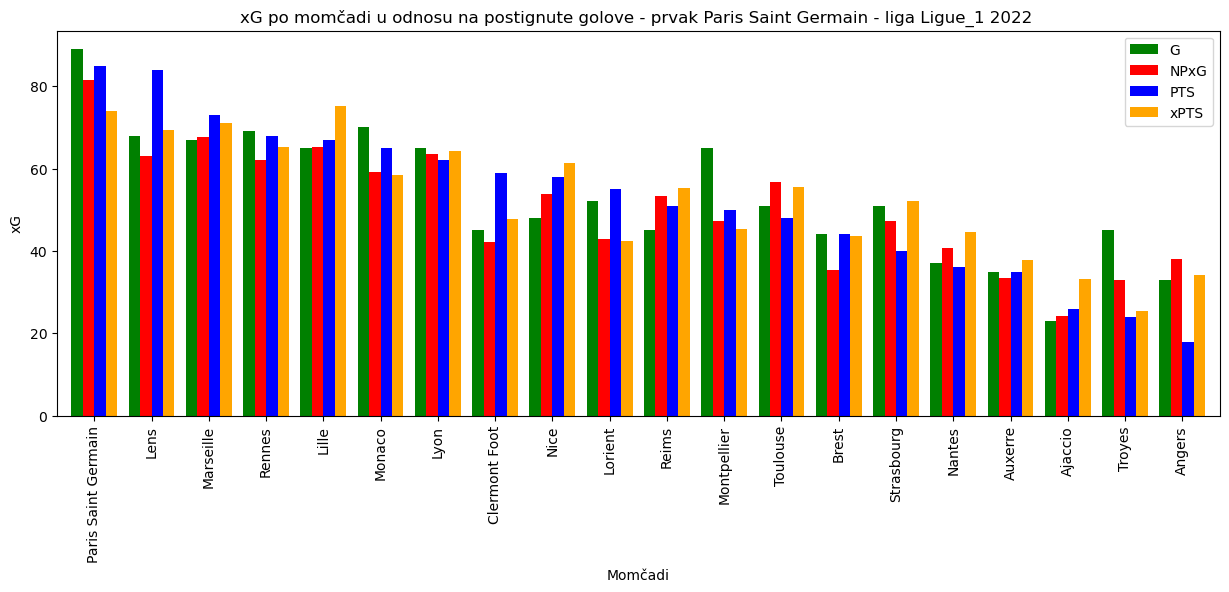

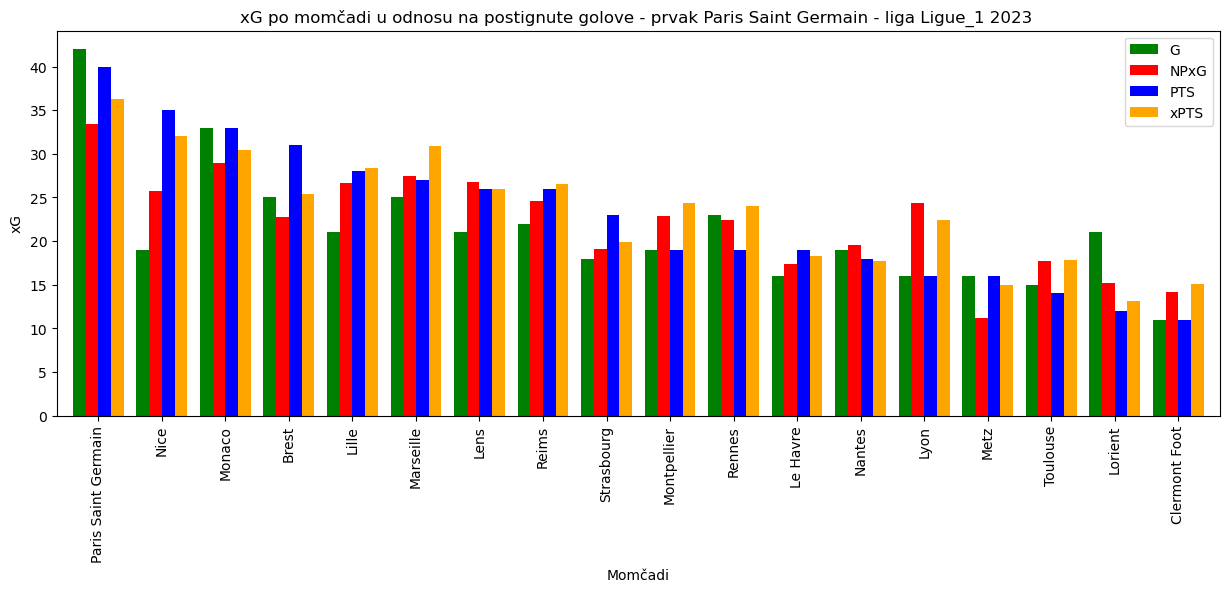

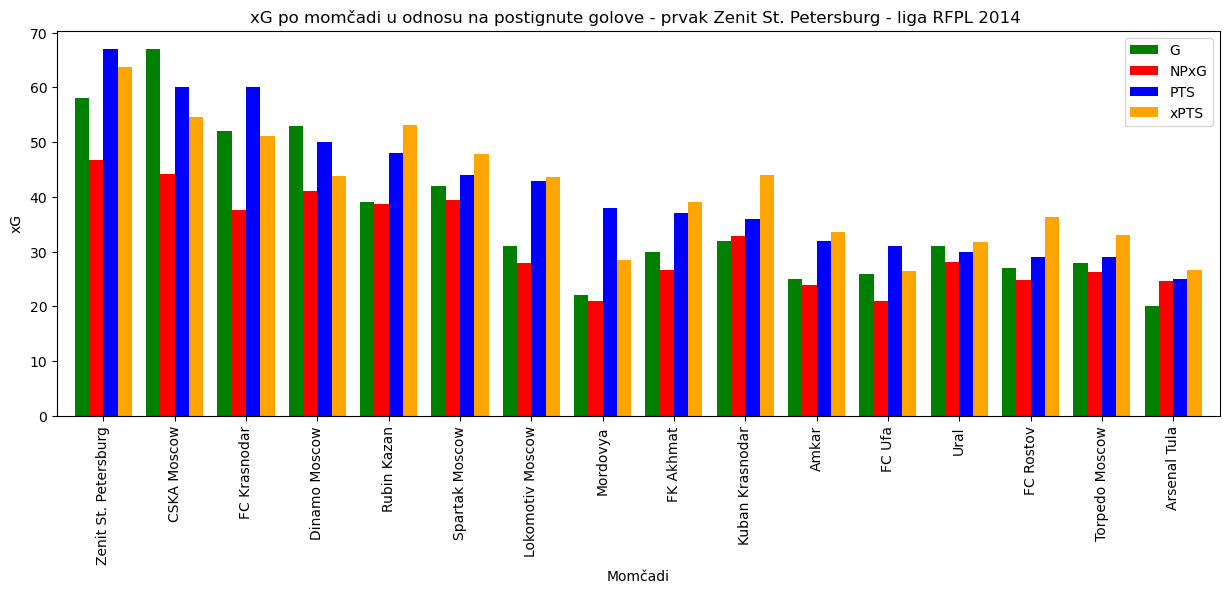

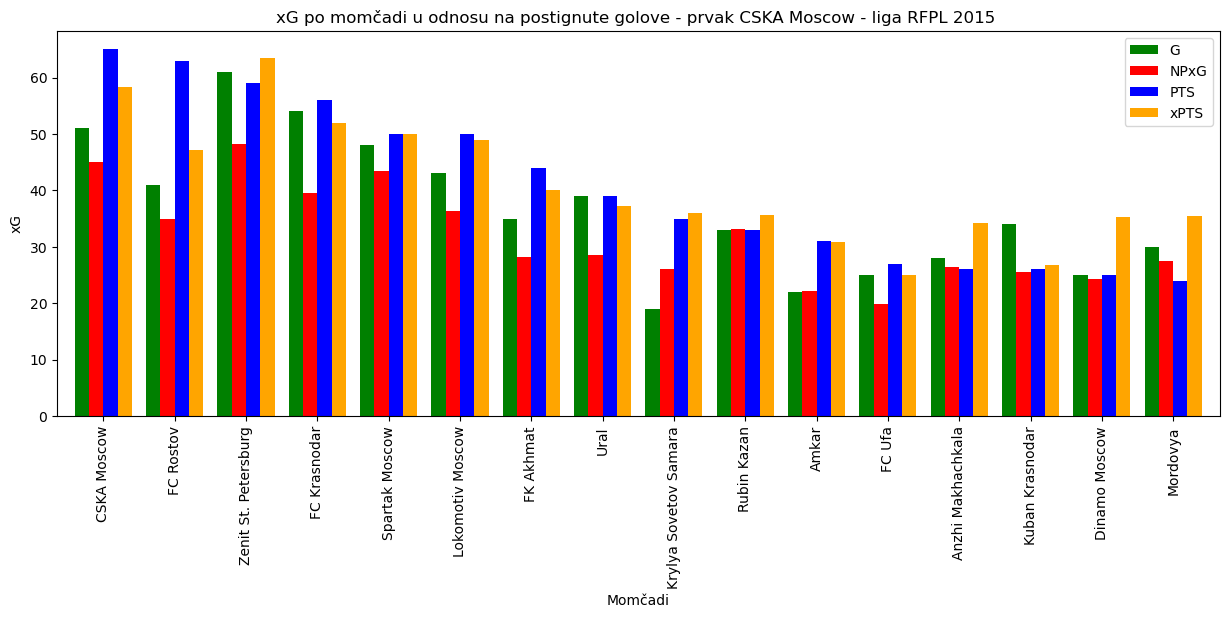

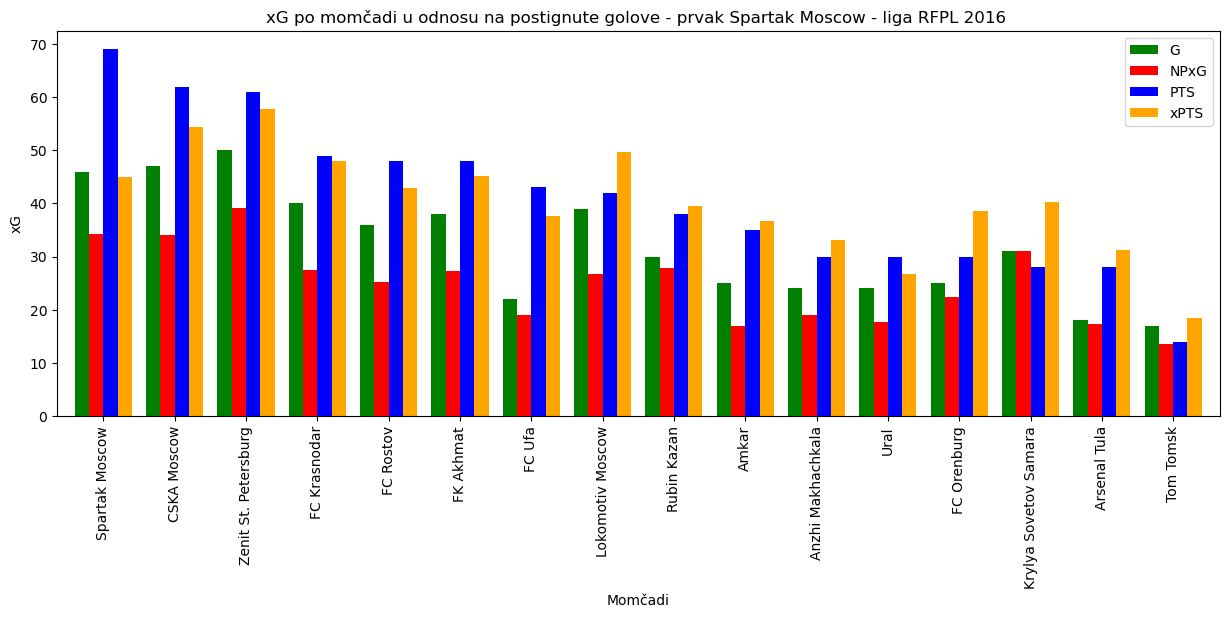

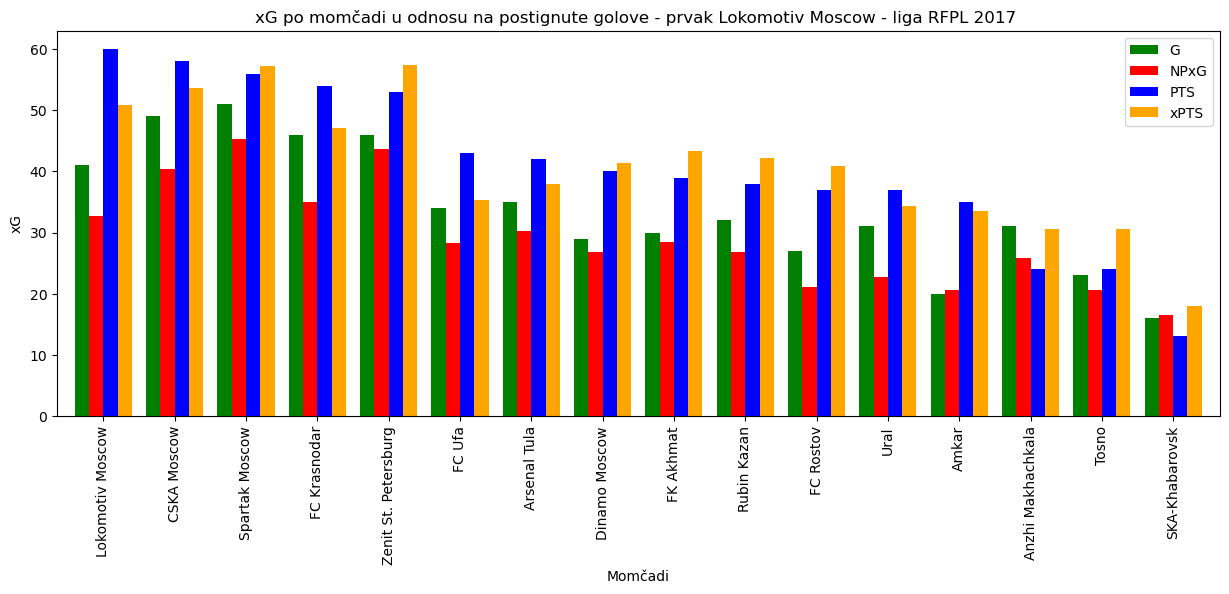

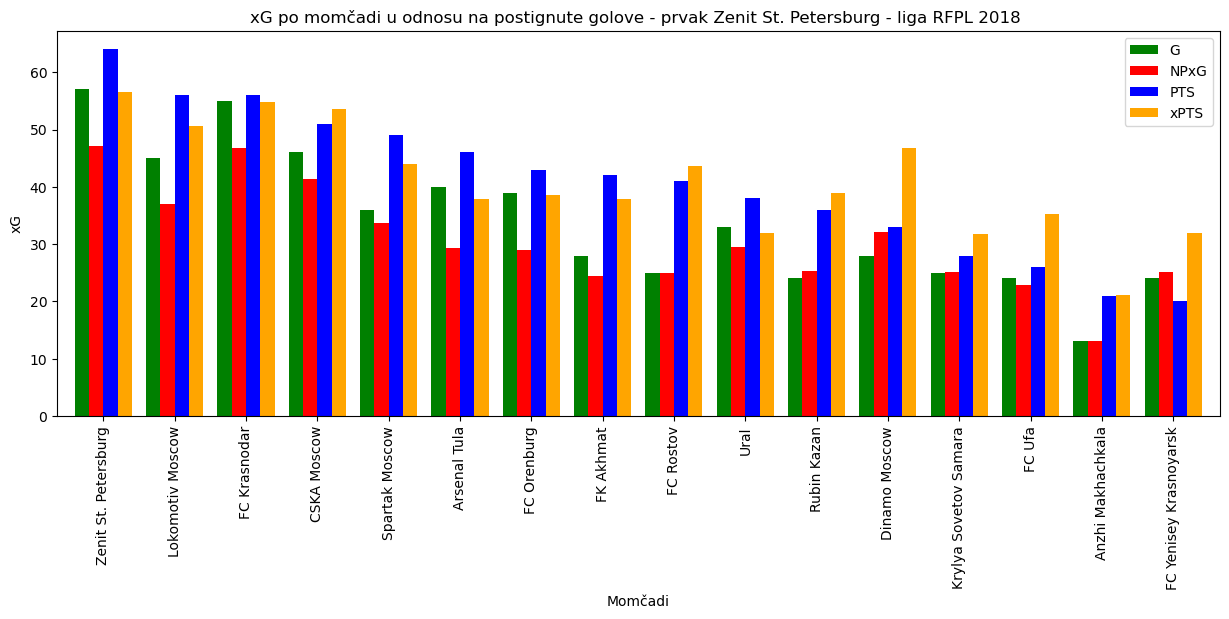

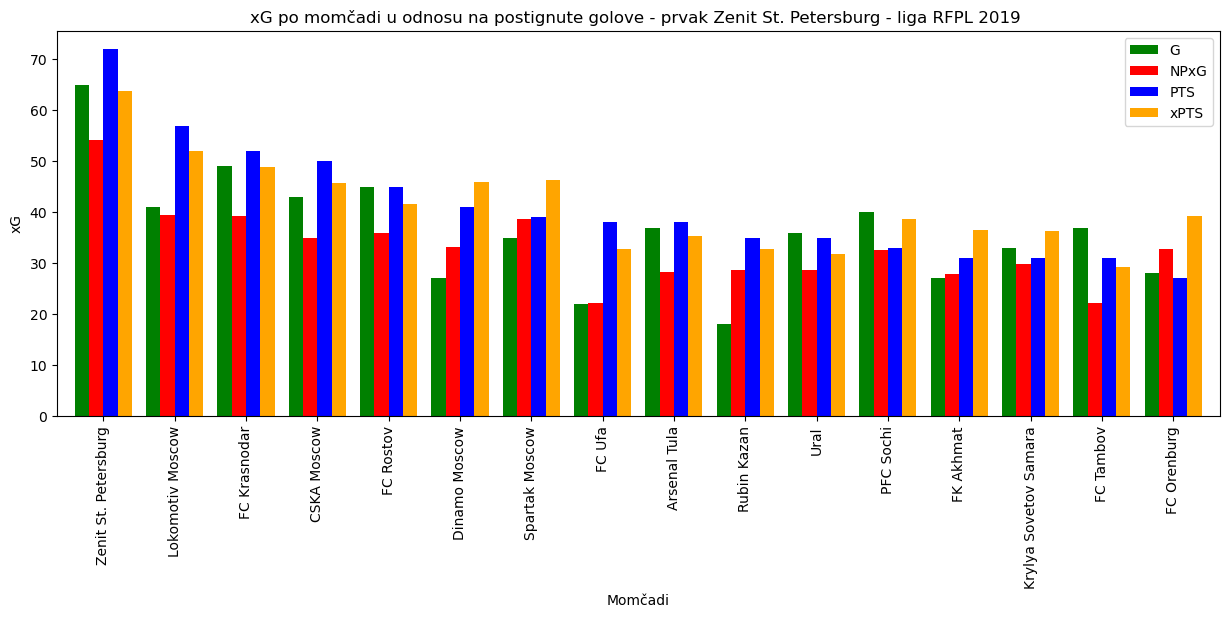

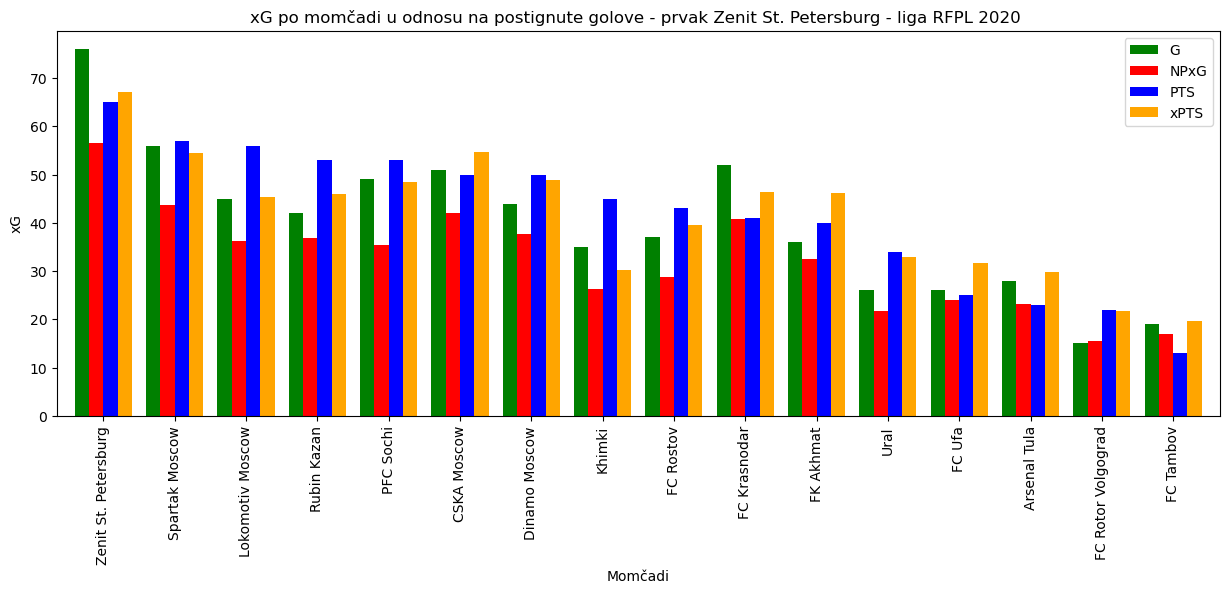

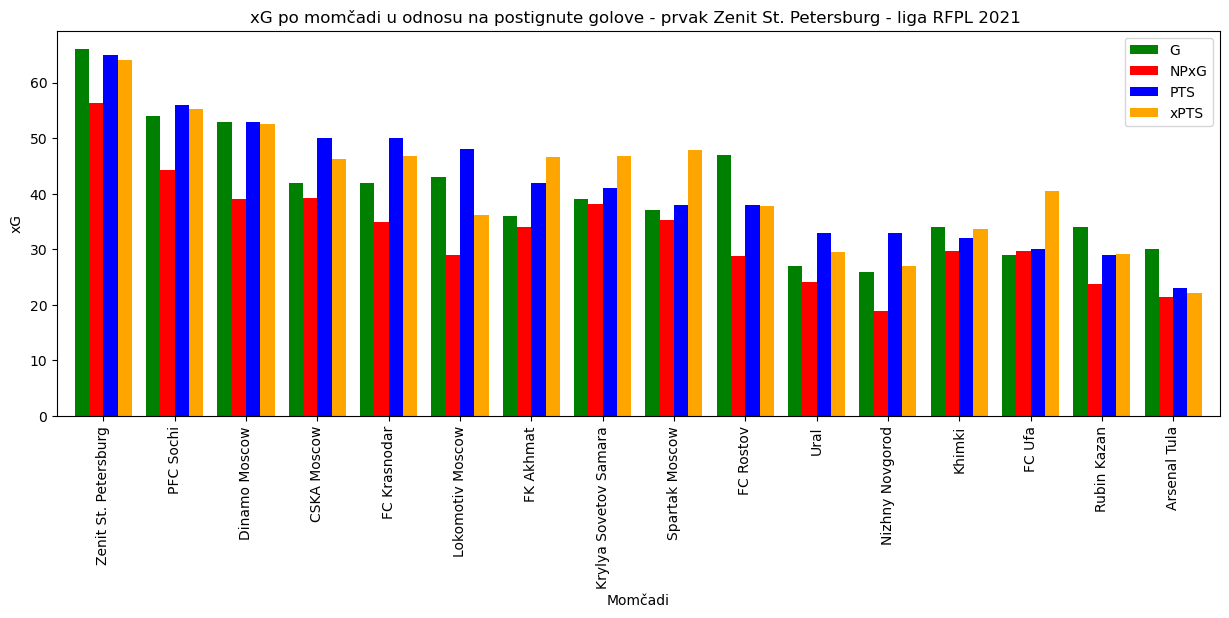

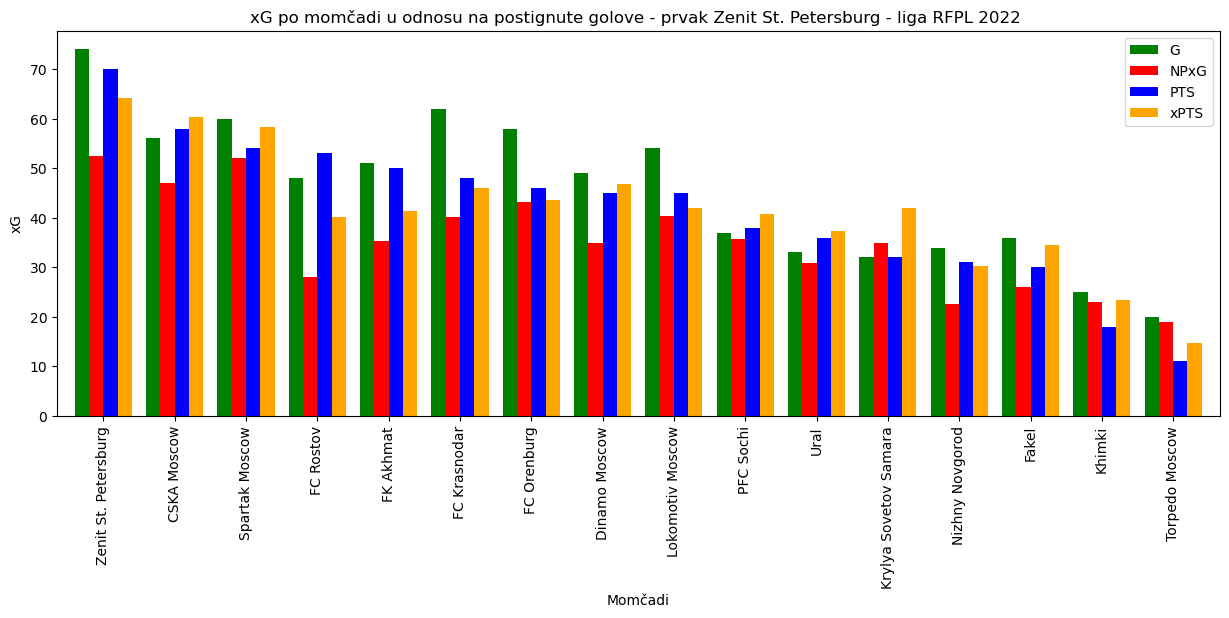

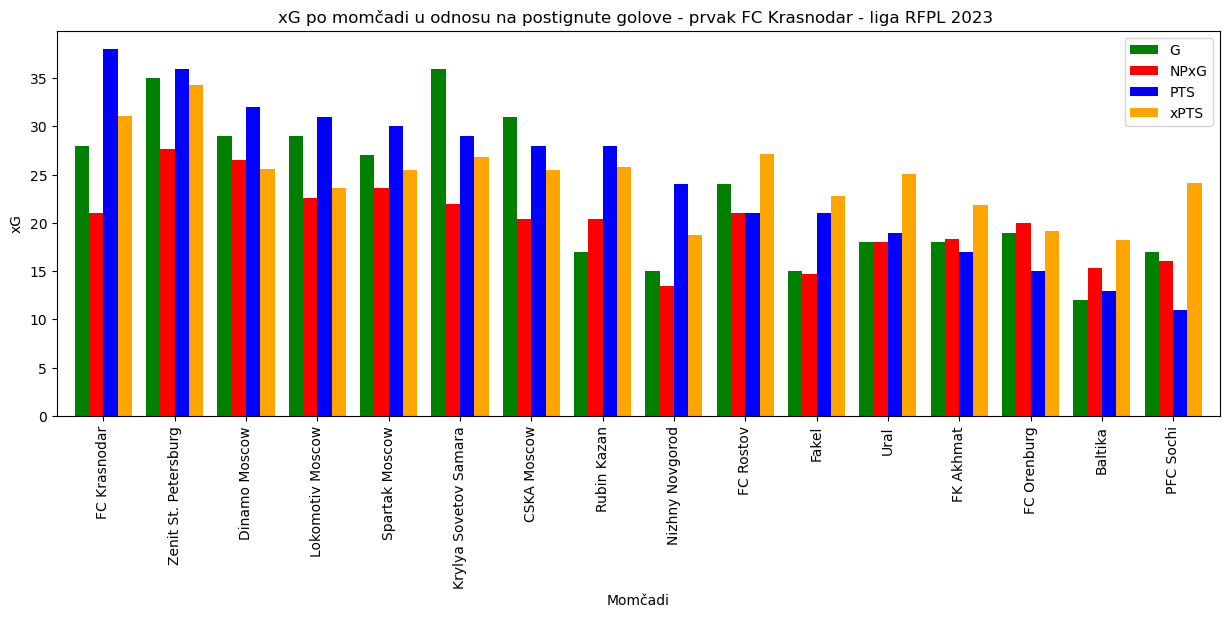

In [14]:
leagues = ['La_liga', 'EPL', 'Bundesliga', 'Serie_A', 'Ligue_1', 'RFPL']
seasons = ['2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']
for league in leagues:
    for season in seasons:    
        url_df = f'{league}_{season}.csv'
        league_df = pd.read_csv(url_df)
        prvak = league_df.loc[0, 'team']
        
        league_df.plot(
        kind='bar',
        width=0.8,

        x='team',
        y=['G', 'NPxG', 'PTS', 'xPTS'],
        xlabel='Momčadi',
        ylabel='xG',
        figsize=(15,5),

        color=['green', 'red', 'blue', 'orange'],
        linestyle='solid',

        legend=True,
        title=f'xG po momčadi u odnosu na postignute golove - prvak {prvak} - liga {league} {season} '
    )

<Axes: title={'center': 'xG po momčadi u odnosu na postignute golove'}, xlabel='Momčadi', ylabel='xG'>

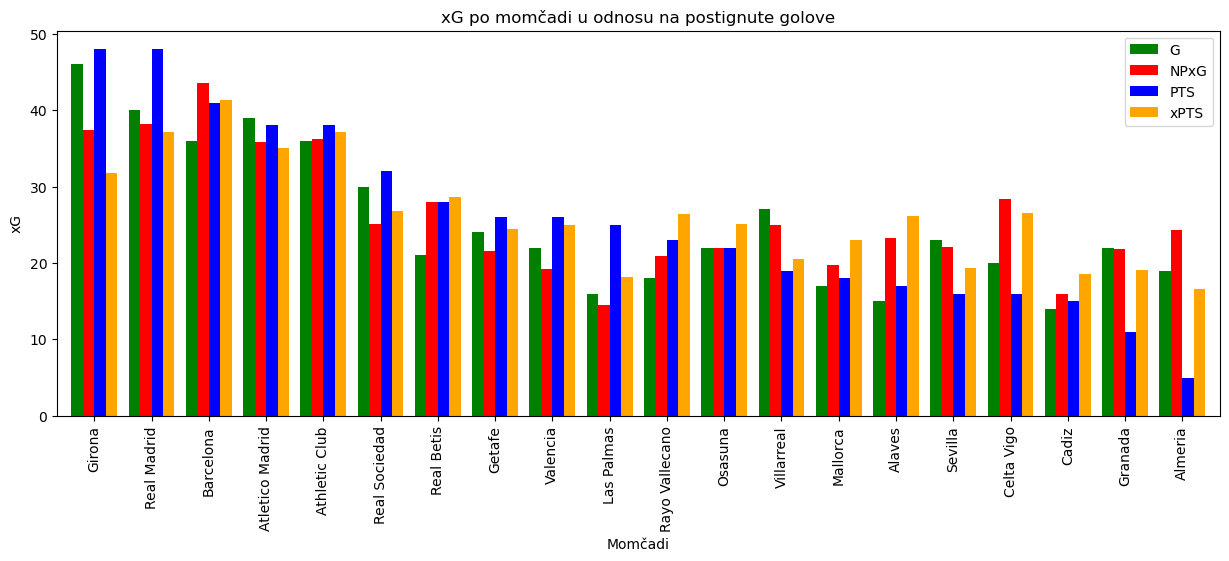